In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : [],
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_e_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2867343, 919)
(2867343, 8)
validation
(519557, 919)
(519557, 8)
test
(237229, 919)
(237229, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 919)]             0         


 dense (Dense)               (None, 1024)              942080    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1632136 (6.23 MB)


Trainable params: 1632136 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/287 [..............................] - ETA: 6:15 - loss: 2.2509 - STD: 0.0865 - MAE: 0.2160

  4/287 [..............................] - ETA: 5s - loss: 2.1180 - STD: 0.0504 - MAE: 0.2166  

  7/287 [..............................] - ETA: 5s - loss: 2.1041 - STD: 0.0467 - MAE: 0.2167

 10/287 [>.............................] - ETA: 5s - loss: 2.0928 - STD: 0.0448 - MAE: 0.2166

 13/287 [>.............................] - ETA: 5s - loss: 2.0827 - STD: 0.0416 - MAE: 0.2166

 16/287 [>.............................] - ETA: 5s - loss: 2.0764 - STD: 0.0406 - MAE: 0.2166

 19/287 [>.............................] - ETA: 4s - loss: 2.0719 - STD: 0.0405 - MAE: 0.2165

 22/287 [=>............................] - ETA: 16s - loss: 2.0662 - STD: 0.0394 - MAE: 0.2164

 25/287 [=>............................] - ETA: 14s - loss: 2.0588 - STD: 0.0389 - MAE: 0.2162

 28/287 [=>............................] - ETA: 13s - loss: 2.0503 - STD: 0.0394 - MAE: 0.2158

 31/287 [==>...........................] - ETA: 12s - loss: 2.0407 - STD: 0.0405 - MAE: 0.2154

 34/287 [==>...........................] - ETA: 11s - loss: 2.0301 - STD: 0.0424 - MAE: 0.2148

 37/287 [==>...........................] - ETA: 10s - loss: 2.0185 - STD: 0.0443 - MAE: 0.2142

 40/287 [===>..........................] - ETA: 10s - loss: 2.0062 - STD: 0.0464 - MAE: 0.2135

 44/287 [===>..........................] - ETA: 9s - loss: 1.9886 - STD: 0.0494 - MAE: 0.2126 

 48/287 [====>.........................] - ETA: 8s - loss: 1.9711 - STD: 0.0524 - MAE: 0.2116

 51/287 [====>.........................] - ETA: 8s - loss: 1.9569 - STD: 0.0547 - MAE: 0.2108

 54/287 [====>.........................] - ETA: 8s - loss: 1.9424 - STD: 0.0570 - MAE: 0.2100

 57/287 [====>.........................] - ETA: 7s - loss: 1.9272 - STD: 0.0594 - MAE: 0.2091

 60/287 [=====>........................] - ETA: 7s - loss: 1.9110 - STD: 0.0618 - MAE: 0.2082

 62/287 [=====>........................] - ETA: 7s - loss: 1.9002 - STD: 0.0634 - MAE: 0.2076

 65/287 [=====>........................] - ETA: 7s - loss: 1.8838 - STD: 0.0659 - MAE: 0.2066

 68/287 [======>.......................] - ETA: 7s - loss: 1.8673 - STD: 0.0683 - MAE: 0.2056

 70/287 [======>.......................] - ETA: 7s - loss: 1.8561 - STD: 0.0699 - MAE: 0.2049

 72/287 [======>.......................] - ETA: 6s - loss: 1.8449 - STD: 0.0715 - MAE: 0.2043

 74/287 [======>.......................] - ETA: 6s - loss: 1.8339 - STD: 0.0730 - MAE: 0.2036

 77/287 [=======>......................] - ETA: 6s - loss: 1.8175 - STD: 0.0754 - MAE: 0.2026

 80/287 [=======>......................] - ETA: 6s - loss: 1.8013 - STD: 0.0777 - MAE: 0.2015

 83/287 [=======>......................] - ETA: 6s - loss: 1.7859 - STD: 0.0800 - MAE: 0.2005

 85/287 [=======>......................] - ETA: 6s - loss: 1.7759 - STD: 0.0815 - MAE: 0.1999

 87/287 [========>.....................] - ETA: 6s - loss: 1.7658 - STD: 0.0830 - MAE: 0.1992

 89/287 [========>.....................] - ETA: 6s - loss: 1.7563 - STD: 0.0845 - MAE: 0.1986

 92/287 [========>.....................] - ETA: 6s - loss: 1.7420 - STD: 0.0867 - MAE: 0.1975

 94/287 [========>.....................] - ETA: 5s - loss: 1.7331 - STD: 0.0881 - MAE: 0.1969

 96/287 [=========>....................] - ETA: 5s - loss: 1.7245 - STD: 0.0895 - MAE: 0.1963

 98/287 [=========>....................] - ETA: 5s - loss: 1.7158 - STD: 0.0909 - MAE: 0.1956

100/287 [=========>....................] - ETA: 5s - loss: 1.7076 - STD: 0.0922 - MAE: 0.1950

102/287 [=========>....................] - ETA: 5s - loss: 1.6992 - STD: 0.0935 - MAE: 0.1944

104/287 [=========>....................] - ETA: 5s - loss: 1.6911 - STD: 0.0948 - MAE: 0.1938

107/287 [==========>...................] - ETA: 5s - loss: 1.6796 - STD: 0.0967 - MAE: 0.1929

109/287 [==========>...................] - ETA: 5s - loss: 1.6721 - STD: 0.0979 - MAE: 0.1924

111/287 [==========>...................] - ETA: 5s - loss: 1.6649 - STD: 0.0991 - MAE: 0.1918

114/287 [==========>...................] - ETA: 5s - loss: 1.6543 - STD: 0.1009 - MAE: 0.1910

116/287 [===========>..................] - ETA: 5s - loss: 1.6474 - STD: 0.1020 - MAE: 0.1904

119/287 [===========>..................] - ETA: 5s - loss: 1.6373 - STD: 0.1036 - MAE: 0.1897

121/287 [===========>..................] - ETA: 4s - loss: 1.6310 - STD: 0.1047 - MAE: 0.1892

124/287 [===========>..................] - ETA: 4s - loss: 1.6214 - STD: 0.1062 - MAE: 0.1884

127/287 [============>.................] - ETA: 4s - loss: 1.6123 - STD: 0.1077 - MAE: 0.1877

130/287 [============>.................] - ETA: 4s - loss: 1.6033 - STD: 0.1091 - MAE: 0.1870

132/287 [============>.................] - ETA: 4s - loss: 1.5975 - STD: 0.1101 - MAE: 0.1865

134/287 [=============>................] - ETA: 4s - loss: 1.5919 - STD: 0.1110 - MAE: 0.1861

137/287 [=============>................] - ETA: 4s - loss: 1.5838 - STD: 0.1124 - MAE: 0.1854

140/287 [=============>................] - ETA: 4s - loss: 1.5761 - STD: 0.1137 - MAE: 0.1848

142/287 [=============>................] - ETA: 4s - loss: 1.5713 - STD: 0.1145 - MAE: 0.1844

144/287 [==============>...............] - ETA: 4s - loss: 1.5663 - STD: 0.1153 - MAE: 0.1840

146/287 [==============>...............] - ETA: 4s - loss: 1.5615 - STD: 0.1162 - MAE: 0.1836

148/287 [==============>...............] - ETA: 4s - loss: 1.5568 - STD: 0.1170 - MAE: 0.1832

150/287 [==============>...............] - ETA: 3s - loss: 1.5522 - STD: 0.1178 - MAE: 0.1828

152/287 [==============>...............] - ETA: 3s - loss: 1.5478 - STD: 0.1185 - MAE: 0.1825

155/287 [===============>..............] - ETA: 3s - loss: 1.5413 - STD: 0.1196 - MAE: 0.1819

157/287 [===============>..............] - ETA: 3s - loss: 1.5370 - STD: 0.1203 - MAE: 0.1816

159/287 [===============>..............] - ETA: 3s - loss: 1.5326 - STD: 0.1211 - MAE: 0.1812

162/287 [===============>..............] - ETA: 3s - loss: 1.5264 - STD: 0.1221 - MAE: 0.1807

165/287 [================>.............] - ETA: 3s - loss: 1.5202 - STD: 0.1231 - MAE: 0.1802

168/287 [================>.............] - ETA: 3s - loss: 1.5144 - STD: 0.1241 - MAE: 0.1797

171/287 [================>.............] - ETA: 3s - loss: 1.5085 - STD: 0.1251 - MAE: 0.1792

174/287 [=================>............] - ETA: 3s - loss: 1.5028 - STD: 0.1260 - MAE: 0.1788

177/287 [=================>............] - ETA: 3s - loss: 1.4972 - STD: 0.1269 - MAE: 0.1783

179/287 [=================>............] - ETA: 3s - loss: 1.4935 - STD: 0.1275 - MAE: 0.1780

181/287 [=================>............] - ETA: 2s - loss: 1.4899 - STD: 0.1281 - MAE: 0.1777

183/287 [==================>...........] - ETA: 2s - loss: 1.4864 - STD: 0.1287 - MAE: 0.1774

185/287 [==================>...........] - ETA: 2s - loss: 1.4829 - STD: 0.1293 - MAE: 0.1771

188/287 [==================>...........] - ETA: 2s - loss: 1.4778 - STD: 0.1301 - MAE: 0.1766

190/287 [==================>...........] - ETA: 2s - loss: 1.4746 - STD: 0.1307 - MAE: 0.1764

192/287 [===================>..........] - ETA: 2s - loss: 1.4714 - STD: 0.1312 - MAE: 0.1761

195/287 [===================>..........] - ETA: 2s - loss: 1.4669 - STD: 0.1320 - MAE: 0.1757

198/287 [===================>..........] - ETA: 2s - loss: 1.4625 - STD: 0.1328 - MAE: 0.1753

200/287 [===================>..........] - ETA: 2s - loss: 1.4594 - STD: 0.1333 - MAE: 0.1751

202/287 [====================>.........] - ETA: 2s - loss: 1.4563 - STD: 0.1338 - MAE: 0.1748

204/287 [====================>.........] - ETA: 2s - loss: 1.4534 - STD: 0.1343 - MAE: 0.1746

206/287 [====================>.........] - ETA: 2s - loss: 1.4505 - STD: 0.1348 - MAE: 0.1743

208/287 [====================>.........] - ETA: 2s - loss: 1.4475 - STD: 0.1352 - MAE: 0.1741

210/287 [====================>.........] - ETA: 2s - loss: 1.4447 - STD: 0.1357 - MAE: 0.1738

213/287 [=====================>........] - ETA: 2s - loss: 1.4406 - STD: 0.1364 - MAE: 0.1735

215/287 [=====================>........] - ETA: 2s - loss: 1.4378 - STD: 0.1369 - MAE: 0.1732

217/287 [=====================>........] - ETA: 1s - loss: 1.4350 - STD: 0.1373 - MAE: 0.1730

219/287 [=====================>........] - ETA: 1s - loss: 1.4324 - STD: 0.1378 - MAE: 0.1728

221/287 [======================>.......] - ETA: 1s - loss: 1.4297 - STD: 0.1382 - MAE: 0.1725

224/287 [======================>.......] - ETA: 1s - loss: 1.4259 - STD: 0.1389 - MAE: 0.1722

227/287 [======================>.......] - ETA: 1s - loss: 1.4219 - STD: 0.1395 - MAE: 0.1718

230/287 [=======================>......] - ETA: 1s - loss: 1.4180 - STD: 0.1401 - MAE: 0.1715

232/287 [=======================>......] - ETA: 1s - loss: 1.4155 - STD: 0.1405 - MAE: 0.1713

235/287 [=======================>......] - ETA: 1s - loss: 1.4118 - STD: 0.1411 - MAE: 0.1710

238/287 [=======================>......] - ETA: 1s - loss: 1.4083 - STD: 0.1417 - MAE: 0.1707

241/287 [========================>.....] - ETA: 1s - loss: 1.4047 - STD: 0.1423 - MAE: 0.1703

244/287 [========================>.....] - ETA: 1s - loss: 1.4013 - STD: 0.1429 - MAE: 0.1700

247/287 [========================>.....] - ETA: 1s - loss: 1.3979 - STD: 0.1435 - MAE: 0.1697

249/287 [=========================>....] - ETA: 1s - loss: 1.3957 - STD: 0.1438 - MAE: 0.1695

251/287 [=========================>....] - ETA: 0s - loss: 1.3934 - STD: 0.1442 - MAE: 0.1693

253/287 [=========================>....] - ETA: 0s - loss: 1.3913 - STD: 0.1446 - MAE: 0.1692

255/287 [=========================>....] - ETA: 0s - loss: 1.3891 - STD: 0.1449 - MAE: 0.1690

257/287 [=========================>....] - ETA: 0s - loss: 1.3870 - STD: 0.1453 - MAE: 0.1688

260/287 [==========================>...] - ETA: 0s - loss: 1.3838 - STD: 0.1458 - MAE: 0.1685

263/287 [==========================>...] - ETA: 0s - loss: 1.3807 - STD: 0.1463 - MAE: 0.1682

266/287 [==========================>...] - ETA: 0s - loss: 1.3775 - STD: 0.1468 - MAE: 0.1679

269/287 [===========================>..] - ETA: 0s - loss: 1.3745 - STD: 0.1473 - MAE: 0.1677

271/287 [===========================>..] - ETA: 0s - loss: 1.3725 - STD: 0.1477 - MAE: 0.1675

273/287 [===========================>..] - ETA: 0s - loss: 1.3706 - STD: 0.1480 - MAE: 0.1673

275/287 [===========================>..] - ETA: 0s - loss: 1.3687 - STD: 0.1483 - MAE: 0.1671

277/287 [===========================>..] - ETA: 0s - loss: 1.3666 - STD: 0.1487 - MAE: 0.1669

280/287 [============================>.] - ETA: 0s - loss: 1.3638 - STD: 0.1491 - MAE: 0.1667

283/287 [============================>.] - ETA: 0s - loss: 1.3609 - STD: 0.1496 - MAE: 0.1664

286/287 [============================>.] - ETA: 0s - loss: 1.3581 - STD: 0.1501 - MAE: 0.1662

287/287 [==============================] - 11s 34ms/step - loss: 1.3572 - STD: 0.1502 - MAE: 0.1661 - val_loss: 1.3522 - val_STD: 0.1913 - val_MAE: 0.1556


Epoch 2/10000


  1/287 [..............................] - ETA: 18s - loss: 1.0888 - STD: 0.1951 - MAE: 0.1415

  3/287 [..............................] - ETA: 7s - loss: 1.0823 - STD: 0.1944 - MAE: 0.1414 

  5/287 [..............................] - ETA: 7s - loss: 1.0956 - STD: 0.1939 - MAE: 0.1424

  7/287 [..............................] - ETA: 7s - loss: 1.0948 - STD: 0.1936 - MAE: 0.1424

  9/287 [..............................] - ETA: 7s - loss: 1.0935 - STD: 0.1935 - MAE: 0.1423

 11/287 [>.............................] - ETA: 7s - loss: 1.0931 - STD: 0.1937 - MAE: 0.1422

 13/287 [>.............................] - ETA: 7s - loss: 1.0910 - STD: 0.1938 - MAE: 0.1420

 15/287 [>.............................] - ETA: 7s - loss: 1.0892 - STD: 0.1939 - MAE: 0.1419

 18/287 [>.............................] - ETA: 6s - loss: 1.0890 - STD: 0.1941 - MAE: 0.1418

 20/287 [=>............................] - ETA: 6s - loss: 1.0884 - STD: 0.1942 - MAE: 0.1418

 22/287 [=>............................] - ETA: 6s - loss: 1.0876 - STD: 0.1943 - MAE: 0.1417

 24/287 [=>............................] - ETA: 6s - loss: 1.0870 - STD: 0.1944 - MAE: 0.1416

 26/287 [=>............................] - ETA: 6s - loss: 1.0866 - STD: 0.1946 - MAE: 0.1415

 28/287 [=>............................] - ETA: 6s - loss: 1.0863 - STD: 0.1948 - MAE: 0.1414

 30/287 [==>...........................] - ETA: 6s - loss: 1.0858 - STD: 0.1949 - MAE: 0.1413

 32/287 [==>...........................] - ETA: 6s - loss: 1.0856 - STD: 0.1950 - MAE: 0.1413

 34/287 [==>...........................] - ETA: 6s - loss: 1.0847 - STD: 0.1951 - MAE: 0.1412

 36/287 [==>...........................] - ETA: 6s - loss: 1.0834 - STD: 0.1952 - MAE: 0.1411

 38/287 [==>...........................] - ETA: 6s - loss: 1.0833 - STD: 0.1953 - MAE: 0.1410

 40/287 [===>..........................] - ETA: 6s - loss: 1.0823 - STD: 0.1954 - MAE: 0.1409

 42/287 [===>..........................] - ETA: 6s - loss: 1.0820 - STD: 0.1955 - MAE: 0.1409

 45/287 [===>..........................] - ETA: 6s - loss: 1.0808 - STD: 0.1956 - MAE: 0.1408

 48/287 [====>.........................] - ETA: 6s - loss: 1.0804 - STD: 0.1957 - MAE: 0.1407

 51/287 [====>.........................] - ETA: 5s - loss: 1.0799 - STD: 0.1958 - MAE: 0.1406

 54/287 [====>.........................] - ETA: 5s - loss: 1.0790 - STD: 0.1959 - MAE: 0.1405

 57/287 [====>.........................] - ETA: 5s - loss: 1.0778 - STD: 0.1960 - MAE: 0.1404

 60/287 [=====>........................] - ETA: 5s - loss: 1.0771 - STD: 0.1962 - MAE: 0.1403

 63/287 [=====>........................] - ETA: 5s - loss: 1.0766 - STD: 0.1963 - MAE: 0.1403

 66/287 [=====>........................] - ETA: 5s - loss: 1.0756 - STD: 0.1964 - MAE: 0.1402

 69/287 [======>.......................] - ETA: 5s - loss: 1.0751 - STD: 0.1965 - MAE: 0.1401

 71/287 [======>.......................] - ETA: 5s - loss: 1.0742 - STD: 0.1967 - MAE: 0.1400

 73/287 [======>.......................] - ETA: 5s - loss: 1.0737 - STD: 0.1967 - MAE: 0.1399

 75/287 [======>.......................] - ETA: 5s - loss: 1.0728 - STD: 0.1968 - MAE: 0.1399

 77/287 [=======>......................] - ETA: 4s - loss: 1.0726 - STD: 0.1969 - MAE: 0.1398

 80/287 [=======>......................] - ETA: 4s - loss: 1.0722 - STD: 0.1970 - MAE: 0.1398

 83/287 [=======>......................] - ETA: 4s - loss: 1.0716 - STD: 0.1971 - MAE: 0.1397

 85/287 [=======>......................] - ETA: 4s - loss: 1.0709 - STD: 0.1972 - MAE: 0.1396

 87/287 [========>.....................] - ETA: 4s - loss: 1.0705 - STD: 0.1973 - MAE: 0.1396

 89/287 [========>.....................] - ETA: 4s - loss: 1.0701 - STD: 0.1974 - MAE: 0.1395

 91/287 [========>.....................] - ETA: 4s - loss: 1.0696 - STD: 0.1974 - MAE: 0.1394

 93/287 [========>.....................] - ETA: 4s - loss: 1.0690 - STD: 0.1974 - MAE: 0.1394

 95/287 [========>.....................] - ETA: 4s - loss: 1.0685 - STD: 0.1975 - MAE: 0.1393

 97/287 [=========>....................] - ETA: 4s - loss: 1.0678 - STD: 0.1976 - MAE: 0.1393

100/287 [=========>....................] - ETA: 4s - loss: 1.0669 - STD: 0.1977 - MAE: 0.1392

102/287 [=========>....................] - ETA: 4s - loss: 1.0663 - STD: 0.1978 - MAE: 0.1391

105/287 [=========>....................] - ETA: 4s - loss: 1.0653 - STD: 0.1978 - MAE: 0.1390

108/287 [==========>...................] - ETA: 4s - loss: 1.0648 - STD: 0.1979 - MAE: 0.1390

110/287 [==========>...................] - ETA: 4s - loss: 1.0642 - STD: 0.1980 - MAE: 0.1389

113/287 [==========>...................] - ETA: 4s - loss: 1.0635 - STD: 0.1981 - MAE: 0.1388

116/287 [===========>..................] - ETA: 4s - loss: 1.0631 - STD: 0.1983 - MAE: 0.1387

119/287 [===========>..................] - ETA: 4s - loss: 1.0627 - STD: 0.1984 - MAE: 0.1387

122/287 [===========>..................] - ETA: 3s - loss: 1.0624 - STD: 0.1985 - MAE: 0.1386

125/287 [============>.................] - ETA: 3s - loss: 1.0620 - STD: 0.1986 - MAE: 0.1386

128/287 [============>.................] - ETA: 3s - loss: 1.0612 - STD: 0.1987 - MAE: 0.1385

131/287 [============>.................] - ETA: 3s - loss: 1.0604 - STD: 0.1988 - MAE: 0.1384

134/287 [=============>................] - ETA: 3s - loss: 1.0594 - STD: 0.1989 - MAE: 0.1383

137/287 [=============>................] - ETA: 3s - loss: 1.0586 - STD: 0.1990 - MAE: 0.1382

139/287 [=============>................] - ETA: 3s - loss: 1.0580 - STD: 0.1990 - MAE: 0.1381

141/287 [=============>................] - ETA: 3s - loss: 1.0573 - STD: 0.1991 - MAE: 0.1381

143/287 [=============>................] - ETA: 3s - loss: 1.0568 - STD: 0.1992 - MAE: 0.1380

145/287 [==============>...............] - ETA: 3s - loss: 1.0562 - STD: 0.1993 - MAE: 0.1379

147/287 [==============>...............] - ETA: 3s - loss: 1.0556 - STD: 0.1994 - MAE: 0.1379

149/287 [==============>...............] - ETA: 3s - loss: 1.0549 - STD: 0.1994 - MAE: 0.1378

151/287 [==============>...............] - ETA: 3s - loss: 1.0543 - STD: 0.1995 - MAE: 0.1378

153/287 [==============>...............] - ETA: 3s - loss: 1.0537 - STD: 0.1996 - MAE: 0.1377

155/287 [===============>..............] - ETA: 3s - loss: 1.0531 - STD: 0.1996 - MAE: 0.1376

157/287 [===============>..............] - ETA: 3s - loss: 1.0526 - STD: 0.1997 - MAE: 0.1376

159/287 [===============>..............] - ETA: 3s - loss: 1.0524 - STD: 0.1998 - MAE: 0.1375

161/287 [===============>..............] - ETA: 3s - loss: 1.0520 - STD: 0.1998 - MAE: 0.1375

163/287 [================>.............] - ETA: 3s - loss: 1.0517 - STD: 0.1999 - MAE: 0.1375

165/287 [================>.............] - ETA: 2s - loss: 1.0512 - STD: 0.1999 - MAE: 0.1374

168/287 [================>.............] - ETA: 2s - loss: 1.0506 - STD: 0.2000 - MAE: 0.1373

171/287 [================>.............] - ETA: 2s - loss: 1.0499 - STD: 0.2001 - MAE: 0.1373

173/287 [=================>............] - ETA: 2s - loss: 1.0494 - STD: 0.2002 - MAE: 0.1372

175/287 [=================>............] - ETA: 2s - loss: 1.0491 - STD: 0.2002 - MAE: 0.1372

177/287 [=================>............] - ETA: 2s - loss: 1.0489 - STD: 0.2003 - MAE: 0.1371

179/287 [=================>............] - ETA: 2s - loss: 1.0486 - STD: 0.2004 - MAE: 0.1371

181/287 [=================>............] - ETA: 2s - loss: 1.0482 - STD: 0.2004 - MAE: 0.1370

183/287 [==================>...........] - ETA: 2s - loss: 1.0479 - STD: 0.2005 - MAE: 0.1370

186/287 [==================>...........] - ETA: 2s - loss: 1.0472 - STD: 0.2005 - MAE: 0.1369

189/287 [==================>...........] - ETA: 2s - loss: 1.0468 - STD: 0.2006 - MAE: 0.1369

192/287 [===================>..........] - ETA: 2s - loss: 1.0463 - STD: 0.2007 - MAE: 0.1368

194/287 [===================>..........] - ETA: 2s - loss: 1.0458 - STD: 0.2008 - MAE: 0.1368

196/287 [===================>..........] - ETA: 2s - loss: 1.0455 - STD: 0.2008 - MAE: 0.1367

198/287 [===================>..........] - ETA: 2s - loss: 1.0451 - STD: 0.2009 - MAE: 0.1367

200/287 [===================>..........] - ETA: 2s - loss: 1.0448 - STD: 0.2010 - MAE: 0.1366

202/287 [====================>.........] - ETA: 2s - loss: 1.0445 - STD: 0.2010 - MAE: 0.1366

204/287 [====================>.........] - ETA: 2s - loss: 1.0441 - STD: 0.2011 - MAE: 0.1365

207/287 [====================>.........] - ETA: 1s - loss: 1.0435 - STD: 0.2012 - MAE: 0.1365

210/287 [====================>.........] - ETA: 1s - loss: 1.0429 - STD: 0.2013 - MAE: 0.1364

213/287 [=====================>........] - ETA: 1s - loss: 1.0422 - STD: 0.2014 - MAE: 0.1363

215/287 [=====================>........] - ETA: 1s - loss: 1.0419 - STD: 0.2014 - MAE: 0.1363

217/287 [=====================>........] - ETA: 1s - loss: 1.0414 - STD: 0.2015 - MAE: 0.1362

219/287 [=====================>........] - ETA: 1s - loss: 1.0410 - STD: 0.2015 - MAE: 0.1362

221/287 [======================>.......] - ETA: 1s - loss: 1.0406 - STD: 0.2016 - MAE: 0.1361

224/287 [======================>.......] - ETA: 1s - loss: 1.0399 - STD: 0.2017 - MAE: 0.1361

227/287 [======================>.......] - ETA: 1s - loss: 1.0395 - STD: 0.2017 - MAE: 0.1360

229/287 [======================>.......] - ETA: 1s - loss: 1.0391 - STD: 0.2018 - MAE: 0.1360

231/287 [=======================>......] - ETA: 1s - loss: 1.0387 - STD: 0.2019 - MAE: 0.1359

233/287 [=======================>......] - ETA: 1s - loss: 1.0383 - STD: 0.2019 - MAE: 0.1359

236/287 [=======================>......] - ETA: 1s - loss: 1.0376 - STD: 0.2020 - MAE: 0.1358

239/287 [=======================>......] - ETA: 1s - loss: 1.0370 - STD: 0.2021 - MAE: 0.1357

242/287 [========================>.....] - ETA: 1s - loss: 1.0364 - STD: 0.2022 - MAE: 0.1357

245/287 [========================>.....] - ETA: 1s - loss: 1.0357 - STD: 0.2022 - MAE: 0.1356

248/287 [========================>.....] - ETA: 0s - loss: 1.0352 - STD: 0.2023 - MAE: 0.1355

251/287 [=========================>....] - ETA: 0s - loss: 1.0345 - STD: 0.2024 - MAE: 0.1355

254/287 [=========================>....] - ETA: 0s - loss: 1.0341 - STD: 0.2025 - MAE: 0.1354

257/287 [=========================>....] - ETA: 0s - loss: 1.0334 - STD: 0.2026 - MAE: 0.1353

260/287 [==========================>...] - ETA: 0s - loss: 1.0329 - STD: 0.2026 - MAE: 0.1353

262/287 [==========================>...] - ETA: 0s - loss: 1.0325 - STD: 0.2027 - MAE: 0.1352

264/287 [==========================>...] - ETA: 0s - loss: 1.0321 - STD: 0.2027 - MAE: 0.1352

266/287 [==========================>...] - ETA: 0s - loss: 1.0317 - STD: 0.2028 - MAE: 0.1351

268/287 [===========================>..] - ETA: 0s - loss: 1.0312 - STD: 0.2028 - MAE: 0.1351

270/287 [===========================>..] - ETA: 0s - loss: 1.0309 - STD: 0.2029 - MAE: 0.1351

272/287 [===========================>..] - ETA: 0s - loss: 1.0305 - STD: 0.2030 - MAE: 0.1350

274/287 [===========================>..] - ETA: 0s - loss: 1.0302 - STD: 0.2030 - MAE: 0.1350

277/287 [===========================>..] - ETA: 0s - loss: 1.0297 - STD: 0.2031 - MAE: 0.1349

280/287 [============================>.] - ETA: 0s - loss: 1.0290 - STD: 0.2032 - MAE: 0.1348

283/287 [============================>.] - ETA: 0s - loss: 1.0284 - STD: 0.2032 - MAE: 0.1348

286/287 [============================>.] - ETA: 0s - loss: 1.0278 - STD: 0.2033 - MAE: 0.1347

287/287 [==============================] - 9s 30ms/step - loss: 1.0277 - STD: 0.2034 - MAE: 0.1347 - val_loss: 1.4815 - val_STD: 0.2112 - val_MAE: 0.1527


Epoch 3/10000


  1/287 [..............................] - ETA: 19s - loss: 0.9868 - STD: 0.2107 - MAE: 0.1295

  4/287 [..............................] - ETA: 7s - loss: 0.9755 - STD: 0.2103 - MAE: 0.1289 

  6/287 [..............................] - ETA: 7s - loss: 0.9717 - STD: 0.2107 - MAE: 0.1285

  8/287 [..............................] - ETA: 7s - loss: 0.9754 - STD: 0.2107 - MAE: 0.1287

 10/287 [>.............................] - ETA: 7s - loss: 0.9740 - STD: 0.2108 - MAE: 0.1286

 12/287 [>.............................] - ETA: 7s - loss: 0.9764 - STD: 0.2108 - MAE: 0.1287

 14/287 [>.............................] - ETA: 7s - loss: 0.9795 - STD: 0.2110 - MAE: 0.1288

 16/287 [>.............................] - ETA: 7s - loss: 0.9794 - STD: 0.2111 - MAE: 0.1288

 18/287 [>.............................] - ETA: 7s - loss: 0.9793 - STD: 0.2111 - MAE: 0.1288

 20/287 [=>............................] - ETA: 7s - loss: 0.9807 - STD: 0.2111 - MAE: 0.1288

 22/287 [=>............................] - ETA: 7s - loss: 0.9799 - STD: 0.2111 - MAE: 0.1288

 24/287 [=>............................] - ETA: 7s - loss: 0.9811 - STD: 0.2111 - MAE: 0.1289

 26/287 [=>............................] - ETA: 7s - loss: 0.9794 - STD: 0.2112 - MAE: 0.1288

 28/287 [=>............................] - ETA: 7s - loss: 0.9802 - STD: 0.2113 - MAE: 0.1288

 30/287 [==>...........................] - ETA: 7s - loss: 0.9790 - STD: 0.2113 - MAE: 0.1287

 32/287 [==>...........................] - ETA: 7s - loss: 0.9773 - STD: 0.2112 - MAE: 0.1286

 34/287 [==>...........................] - ETA: 7s - loss: 0.9765 - STD: 0.2113 - MAE: 0.1285

 36/287 [==>...........................] - ETA: 7s - loss: 0.9753 - STD: 0.2114 - MAE: 0.1284

 38/287 [==>...........................] - ETA: 7s - loss: 0.9751 - STD: 0.2114 - MAE: 0.1284

 40/287 [===>..........................] - ETA: 7s - loss: 0.9737 - STD: 0.2114 - MAE: 0.1283

 42/287 [===>..........................] - ETA: 7s - loss: 0.9735 - STD: 0.2114 - MAE: 0.1283

 44/287 [===>..........................] - ETA: 7s - loss: 0.9726 - STD: 0.2115 - MAE: 0.1282

 46/287 [===>..........................] - ETA: 7s - loss: 0.9728 - STD: 0.2115 - MAE: 0.1282

 48/287 [====>.........................] - ETA: 7s - loss: 0.9717 - STD: 0.2115 - MAE: 0.1281

 50/287 [====>.........................] - ETA: 7s - loss: 0.9712 - STD: 0.2115 - MAE: 0.1281

 52/287 [====>.........................] - ETA: 7s - loss: 0.9709 - STD: 0.2115 - MAE: 0.1281

 55/287 [====>.........................] - ETA: 6s - loss: 0.9701 - STD: 0.2116 - MAE: 0.1280

 58/287 [=====>........................] - ETA: 6s - loss: 0.9690 - STD: 0.2117 - MAE: 0.1279

 60/287 [=====>........................] - ETA: 6s - loss: 0.9687 - STD: 0.2117 - MAE: 0.1278

 63/287 [=====>........................] - ETA: 6s - loss: 0.9683 - STD: 0.2118 - MAE: 0.1278

 66/287 [=====>........................] - ETA: 6s - loss: 0.9699 - STD: 0.2119 - MAE: 0.1278

 68/287 [======>.......................] - ETA: 6s - loss: 0.9706 - STD: 0.2120 - MAE: 0.1278

 71/287 [======>.......................] - ETA: 6s - loss: 0.9706 - STD: 0.2120 - MAE: 0.1278

 73/287 [======>.......................] - ETA: 6s - loss: 0.9705 - STD: 0.2120 - MAE: 0.1278

 76/287 [======>.......................] - ETA: 5s - loss: 0.9698 - STD: 0.2121 - MAE: 0.1278

 78/287 [=======>......................] - ETA: 5s - loss: 0.9694 - STD: 0.2121 - MAE: 0.1277

 81/287 [=======>......................] - ETA: 5s - loss: 0.9688 - STD: 0.2121 - MAE: 0.1277

 83/287 [=======>......................] - ETA: 5s - loss: 0.9683 - STD: 0.2121 - MAE: 0.1276

 85/287 [=======>......................] - ETA: 5s - loss: 0.9674 - STD: 0.2122 - MAE: 0.1276

 87/287 [========>.....................] - ETA: 5s - loss: 0.9668 - STD: 0.2122 - MAE: 0.1275

 89/287 [========>.....................] - ETA: 5s - loss: 0.9662 - STD: 0.2123 - MAE: 0.1275

 91/287 [========>.....................] - ETA: 5s - loss: 0.9660 - STD: 0.2123 - MAE: 0.1274

 93/287 [========>.....................] - ETA: 5s - loss: 0.9657 - STD: 0.2124 - MAE: 0.1274

 95/287 [========>.....................] - ETA: 5s - loss: 0.9654 - STD: 0.2124 - MAE: 0.1274

 97/287 [=========>....................] - ETA: 5s - loss: 0.9654 - STD: 0.2124 - MAE: 0.1273

100/287 [=========>....................] - ETA: 5s - loss: 0.9647 - STD: 0.2125 - MAE: 0.1273

103/287 [=========>....................] - ETA: 5s - loss: 0.9645 - STD: 0.2125 - MAE: 0.1272

106/287 [==========>...................] - ETA: 5s - loss: 0.9640 - STD: 0.2126 - MAE: 0.1272

109/287 [==========>...................] - ETA: 4s - loss: 0.9638 - STD: 0.2127 - MAE: 0.1272

112/287 [==========>...................] - ETA: 4s - loss: 0.9635 - STD: 0.2127 - MAE: 0.1271

114/287 [==========>...................] - ETA: 4s - loss: 0.9631 - STD: 0.2127 - MAE: 0.1271

116/287 [===========>..................] - ETA: 4s - loss: 0.9629 - STD: 0.2128 - MAE: 0.1271

119/287 [===========>..................] - ETA: 4s - loss: 0.9625 - STD: 0.2128 - MAE: 0.1270

121/287 [===========>..................] - ETA: 4s - loss: 0.9621 - STD: 0.2128 - MAE: 0.1270

123/287 [===========>..................] - ETA: 4s - loss: 0.9619 - STD: 0.2128 - MAE: 0.1269

125/287 [============>.................] - ETA: 4s - loss: 0.9615 - STD: 0.2129 - MAE: 0.1269

127/287 [============>.................] - ETA: 4s - loss: 0.9610 - STD: 0.2129 - MAE: 0.1269

129/287 [============>.................] - ETA: 4s - loss: 0.9608 - STD: 0.2129 - MAE: 0.1269

131/287 [============>.................] - ETA: 4s - loss: 0.9604 - STD: 0.2130 - MAE: 0.1268

133/287 [============>.................] - ETA: 4s - loss: 0.9603 - STD: 0.2130 - MAE: 0.1268

135/287 [=============>................] - ETA: 4s - loss: 0.9600 - STD: 0.2130 - MAE: 0.1268

137/287 [=============>................] - ETA: 4s - loss: 0.9598 - STD: 0.2131 - MAE: 0.1267

139/287 [=============>................] - ETA: 4s - loss: 0.9596 - STD: 0.2131 - MAE: 0.1267

141/287 [=============>................] - ETA: 4s - loss: 0.9594 - STD: 0.2131 - MAE: 0.1267

143/287 [=============>................] - ETA: 4s - loss: 0.9594 - STD: 0.2132 - MAE: 0.1267

145/287 [==============>...............] - ETA: 4s - loss: 0.9593 - STD: 0.2132 - MAE: 0.1266

147/287 [==============>...............] - ETA: 3s - loss: 0.9591 - STD: 0.2133 - MAE: 0.1266

149/287 [==============>...............] - ETA: 3s - loss: 0.9588 - STD: 0.2133 - MAE: 0.1266

151/287 [==============>...............] - ETA: 3s - loss: 0.9587 - STD: 0.2133 - MAE: 0.1266

153/287 [==============>...............] - ETA: 3s - loss: 0.9584 - STD: 0.2134 - MAE: 0.1265

155/287 [===============>..............] - ETA: 3s - loss: 0.9580 - STD: 0.2134 - MAE: 0.1265

157/287 [===============>..............] - ETA: 3s - loss: 0.9578 - STD: 0.2134 - MAE: 0.1265

159/287 [===============>..............] - ETA: 3s - loss: 0.9576 - STD: 0.2135 - MAE: 0.1264

161/287 [===============>..............] - ETA: 3s - loss: 0.9576 - STD: 0.2135 - MAE: 0.1264

163/287 [================>.............] - ETA: 3s - loss: 0.9577 - STD: 0.2135 - MAE: 0.1264

165/287 [================>.............] - ETA: 3s - loss: 0.9576 - STD: 0.2136 - MAE: 0.1264

167/287 [================>.............] - ETA: 3s - loss: 0.9582 - STD: 0.2136 - MAE: 0.1264

169/287 [================>.............] - ETA: 3s - loss: 0.9581 - STD: 0.2136 - MAE: 0.1264

172/287 [================>.............] - ETA: 3s - loss: 0.9579 - STD: 0.2137 - MAE: 0.1264

175/287 [=================>............] - ETA: 3s - loss: 0.9577 - STD: 0.2137 - MAE: 0.1263

177/287 [=================>............] - ETA: 3s - loss: 0.9575 - STD: 0.2137 - MAE: 0.1263

179/287 [=================>............] - ETA: 3s - loss: 0.9572 - STD: 0.2137 - MAE: 0.1263

181/287 [=================>............] - ETA: 2s - loss: 0.9569 - STD: 0.2138 - MAE: 0.1263

184/287 [==================>...........] - ETA: 2s - loss: 0.9566 - STD: 0.2138 - MAE: 0.1262

187/287 [==================>...........] - ETA: 2s - loss: 0.9560 - STD: 0.2138 - MAE: 0.1262

190/287 [==================>...........] - ETA: 2s - loss: 0.9555 - STD: 0.2139 - MAE: 0.1261

192/287 [===================>..........] - ETA: 2s - loss: 0.9551 - STD: 0.2139 - MAE: 0.1261

194/287 [===================>..........] - ETA: 2s - loss: 0.9548 - STD: 0.2139 - MAE: 0.1261

196/287 [===================>..........] - ETA: 2s - loss: 0.9545 - STD: 0.2139 - MAE: 0.1260

199/287 [===================>..........] - ETA: 2s - loss: 0.9538 - STD: 0.2140 - MAE: 0.1260

201/287 [====================>.........] - ETA: 2s - loss: 0.9536 - STD: 0.2140 - MAE: 0.1259

204/287 [====================>.........] - ETA: 2s - loss: 0.9531 - STD: 0.2141 - MAE: 0.1259

207/287 [====================>.........] - ETA: 2s - loss: 0.9525 - STD: 0.2141 - MAE: 0.1258

209/287 [====================>.........] - ETA: 2s - loss: 0.9522 - STD: 0.2141 - MAE: 0.1258

212/287 [=====================>........] - ETA: 2s - loss: 0.9518 - STD: 0.2142 - MAE: 0.1257

215/287 [=====================>........] - ETA: 1s - loss: 0.9514 - STD: 0.2142 - MAE: 0.1257

217/287 [=====================>........] - ETA: 1s - loss: 0.9511 - STD: 0.2143 - MAE: 0.1257

220/287 [=====================>........] - ETA: 1s - loss: 0.9506 - STD: 0.2143 - MAE: 0.1256

222/287 [======================>.......] - ETA: 1s - loss: 0.9502 - STD: 0.2144 - MAE: 0.1256

225/287 [======================>.......] - ETA: 1s - loss: 0.9497 - STD: 0.2144 - MAE: 0.1255

228/287 [======================>.......] - ETA: 1s - loss: 0.9491 - STD: 0.2145 - MAE: 0.1255

231/287 [=======================>......] - ETA: 1s - loss: 0.9486 - STD: 0.2145 - MAE: 0.1254

234/287 [=======================>......] - ETA: 1s - loss: 0.9481 - STD: 0.2146 - MAE: 0.1254

237/287 [=======================>......] - ETA: 1s - loss: 0.9477 - STD: 0.2146 - MAE: 0.1253

240/287 [========================>.....] - ETA: 1s - loss: 0.9472 - STD: 0.2146 - MAE: 0.1253

243/287 [========================>.....] - ETA: 1s - loss: 0.9467 - STD: 0.2147 - MAE: 0.1252

246/287 [========================>.....] - ETA: 1s - loss: 0.9462 - STD: 0.2148 - MAE: 0.1252

248/287 [========================>.....] - ETA: 1s - loss: 0.9461 - STD: 0.2148 - MAE: 0.1251

251/287 [=========================>....] - ETA: 0s - loss: 0.9466 - STD: 0.2149 - MAE: 0.1251

254/287 [=========================>....] - ETA: 0s - loss: 0.9466 - STD: 0.2149 - MAE: 0.1251

256/287 [=========================>....] - ETA: 0s - loss: 0.9466 - STD: 0.2150 - MAE: 0.1251

258/287 [=========================>....] - ETA: 0s - loss: 0.9463 - STD: 0.2150 - MAE: 0.1250

261/287 [==========================>...] - ETA: 0s - loss: 0.9461 - STD: 0.2151 - MAE: 0.1250

264/287 [==========================>...] - ETA: 0s - loss: 0.9458 - STD: 0.2151 - MAE: 0.1250

267/287 [==========================>...] - ETA: 0s - loss: 0.9454 - STD: 0.2151 - MAE: 0.1249

270/287 [===========================>..] - ETA: 0s - loss: 0.9450 - STD: 0.2152 - MAE: 0.1249

272/287 [===========================>..] - ETA: 0s - loss: 0.9448 - STD: 0.2152 - MAE: 0.1249

275/287 [===========================>..] - ETA: 0s - loss: 0.9444 - STD: 0.2153 - MAE: 0.1248

277/287 [===========================>..] - ETA: 0s - loss: 0.9440 - STD: 0.2153 - MAE: 0.1248

279/287 [============================>.] - ETA: 0s - loss: 0.9437 - STD: 0.2153 - MAE: 0.1248

281/287 [============================>.] - ETA: 0s - loss: 0.9436 - STD: 0.2153 - MAE: 0.1247

283/287 [============================>.] - ETA: 0s - loss: 0.9432 - STD: 0.2154 - MAE: 0.1247

285/287 [============================>.] - ETA: 0s - loss: 0.9430 - STD: 0.2154 - MAE: 0.1247

287/287 [==============================] - ETA: 0s - loss: 0.9428 - STD: 0.2154 - MAE: 0.1247

287/287 [==============================] - 9s 31ms/step - loss: 0.9428 - STD: 0.2154 - MAE: 0.1247 - val_loss: 1.5810 - val_STD: 0.2213 - val_MAE: 0.1519


Epoch 4/10000


  1/287 [..............................] - ETA: 19s - loss: 0.9040 - STD: 0.2199 - MAE: 0.1202

  3/287 [..............................] - ETA: 9s - loss: 0.9045 - STD: 0.2200 - MAE: 0.1202 

  5/287 [..............................] - ETA: 8s - loss: 0.9019 - STD: 0.2194 - MAE: 0.1204

  7/287 [..............................] - ETA: 9s - loss: 0.9062 - STD: 0.2197 - MAE: 0.1206

  9/287 [..............................] - ETA: 9s - loss: 0.9068 - STD: 0.2202 - MAE: 0.1204

 11/287 [>.............................] - ETA: 8s - loss: 0.9055 - STD: 0.2204 - MAE: 0.1202

 13/287 [>.............................] - ETA: 8s - loss: 0.9034 - STD: 0.2203 - MAE: 0.1201

 16/287 [>.............................] - ETA: 8s - loss: 0.9021 - STD: 0.2200 - MAE: 0.1201

 18/287 [>.............................] - ETA: 8s - loss: 0.9024 - STD: 0.2200 - MAE: 0.1202

 20/287 [=>............................] - ETA: 7s - loss: 0.9026 - STD: 0.2202 - MAE: 0.1201

 22/287 [=>............................] - ETA: 7s - loss: 0.9026 - STD: 0.2202 - MAE: 0.1201

 24/287 [=>............................] - ETA: 7s - loss: 0.9015 - STD: 0.2203 - MAE: 0.1200

 27/287 [=>............................] - ETA: 7s - loss: 0.9014 - STD: 0.2202 - MAE: 0.1200

 30/287 [==>...........................] - ETA: 6s - loss: 0.9027 - STD: 0.2202 - MAE: 0.1201

 32/287 [==>...........................] - ETA: 6s - loss: 0.9035 - STD: 0.2204 - MAE: 0.1201

 34/287 [==>...........................] - ETA: 6s - loss: 0.9032 - STD: 0.2205 - MAE: 0.1200

 36/287 [==>...........................] - ETA: 6s - loss: 0.9025 - STD: 0.2205 - MAE: 0.1200

 39/287 [===>..........................] - ETA: 6s - loss: 0.9031 - STD: 0.2206 - MAE: 0.1199

 42/287 [===>..........................] - ETA: 6s - loss: 0.9029 - STD: 0.2206 - MAE: 0.1199

 45/287 [===>..........................] - ETA: 6s - loss: 0.9028 - STD: 0.2207 - MAE: 0.1199

 48/287 [====>.........................] - ETA: 6s - loss: 0.9022 - STD: 0.2206 - MAE: 0.1199

 50/287 [====>.........................] - ETA: 6s - loss: 0.9019 - STD: 0.2207 - MAE: 0.1199

 52/287 [====>.........................] - ETA: 6s - loss: 0.9019 - STD: 0.2207 - MAE: 0.1198

 54/287 [====>.........................] - ETA: 6s - loss: 0.9025 - STD: 0.2208 - MAE: 0.1198

 56/287 [====>.........................] - ETA: 6s - loss: 0.9025 - STD: 0.2208 - MAE: 0.1198

 58/287 [=====>........................] - ETA: 6s - loss: 0.9025 - STD: 0.2209 - MAE: 0.1198

 60/287 [=====>........................] - ETA: 6s - loss: 0.9037 - STD: 0.2209 - MAE: 0.1199

 62/287 [=====>........................] - ETA: 6s - loss: 0.9037 - STD: 0.2209 - MAE: 0.1199

 64/287 [=====>........................] - ETA: 6s - loss: 0.9038 - STD: 0.2209 - MAE: 0.1198

 66/287 [=====>........................] - ETA: 6s - loss: 0.9035 - STD: 0.2209 - MAE: 0.1198

 68/287 [======>.......................] - ETA: 6s - loss: 0.9030 - STD: 0.2209 - MAE: 0.1198

 70/287 [======>.......................] - ETA: 6s - loss: 0.9030 - STD: 0.2210 - MAE: 0.1198

 72/287 [======>.......................] - ETA: 5s - loss: 0.9024 - STD: 0.2210 - MAE: 0.1198

 75/287 [======>.......................] - ETA: 5s - loss: 0.9020 - STD: 0.2210 - MAE: 0.1197

 78/287 [=======>......................] - ETA: 5s - loss: 0.9014 - STD: 0.2210 - MAE: 0.1197

 81/287 [=======>......................] - ETA: 5s - loss: 0.9008 - STD: 0.2211 - MAE: 0.1196

 84/287 [=======>......................] - ETA: 5s - loss: 0.9005 - STD: 0.2212 - MAE: 0.1196

 86/287 [=======>......................] - ETA: 5s - loss: 0.9001 - STD: 0.2212 - MAE: 0.1195

 88/287 [========>.....................] - ETA: 5s - loss: 0.8998 - STD: 0.2211 - MAE: 0.1195

 90/287 [========>.....................] - ETA: 5s - loss: 0.8995 - STD: 0.2212 - MAE: 0.1195

 92/287 [========>.....................] - ETA: 5s - loss: 0.8993 - STD: 0.2212 - MAE: 0.1195

 94/287 [========>.....................] - ETA: 5s - loss: 0.8988 - STD: 0.2212 - MAE: 0.1194

 96/287 [=========>....................] - ETA: 5s - loss: 0.8985 - STD: 0.2213 - MAE: 0.1194

 98/287 [=========>....................] - ETA: 5s - loss: 0.8983 - STD: 0.2213 - MAE: 0.1194

100/287 [=========>....................] - ETA: 5s - loss: 0.8984 - STD: 0.2213 - MAE: 0.1194

102/287 [=========>....................] - ETA: 5s - loss: 0.8983 - STD: 0.2213 - MAE: 0.1194

105/287 [=========>....................] - ETA: 4s - loss: 0.8981 - STD: 0.2213 - MAE: 0.1193

108/287 [==========>...................] - ETA: 4s - loss: 0.8977 - STD: 0.2214 - MAE: 0.1193

111/287 [==========>...................] - ETA: 4s - loss: 0.8976 - STD: 0.2214 - MAE: 0.1193

114/287 [==========>...................] - ETA: 4s - loss: 0.8970 - STD: 0.2214 - MAE: 0.1192

117/287 [===========>..................] - ETA: 4s - loss: 0.8963 - STD: 0.2215 - MAE: 0.1191

120/287 [===========>..................] - ETA: 4s - loss: 0.8962 - STD: 0.2215 - MAE: 0.1191

123/287 [===========>..................] - ETA: 4s - loss: 0.8956 - STD: 0.2216 - MAE: 0.1191

126/287 [============>.................] - ETA: 4s - loss: 0.8952 - STD: 0.2216 - MAE: 0.1190

129/287 [============>.................] - ETA: 4s - loss: 0.8957 - STD: 0.2217 - MAE: 0.1190

132/287 [============>.................] - ETA: 4s - loss: 0.8961 - STD: 0.2217 - MAE: 0.1190

134/287 [=============>................] - ETA: 4s - loss: 0.8958 - STD: 0.2218 - MAE: 0.1190

137/287 [=============>................] - ETA: 3s - loss: 0.8957 - STD: 0.2218 - MAE: 0.1190

140/287 [=============>................] - ETA: 3s - loss: 0.8958 - STD: 0.2218 - MAE: 0.1190

142/287 [=============>................] - ETA: 3s - loss: 0.8956 - STD: 0.2219 - MAE: 0.1189

144/287 [==============>...............] - ETA: 3s - loss: 0.8954 - STD: 0.2219 - MAE: 0.1189

147/287 [==============>...............] - ETA: 3s - loss: 0.8954 - STD: 0.2219 - MAE: 0.1189

149/287 [==============>...............] - ETA: 3s - loss: 0.8952 - STD: 0.2219 - MAE: 0.1189

151/287 [==============>...............] - ETA: 3s - loss: 0.8954 - STD: 0.2219 - MAE: 0.1189

153/287 [==============>...............] - ETA: 3s - loss: 0.8952 - STD: 0.2219 - MAE: 0.1189

155/287 [===============>..............] - ETA: 3s - loss: 0.8950 - STD: 0.2220 - MAE: 0.1189

157/287 [===============>..............] - ETA: 3s - loss: 0.8947 - STD: 0.2220 - MAE: 0.1188

159/287 [===============>..............] - ETA: 3s - loss: 0.8944 - STD: 0.2220 - MAE: 0.1188

161/287 [===============>..............] - ETA: 3s - loss: 0.8942 - STD: 0.2220 - MAE: 0.1188

163/287 [================>.............] - ETA: 3s - loss: 0.8939 - STD: 0.2220 - MAE: 0.1187

166/287 [================>.............] - ETA: 3s - loss: 0.8937 - STD: 0.2221 - MAE: 0.1187

169/287 [================>.............] - ETA: 3s - loss: 0.8934 - STD: 0.2221 - MAE: 0.1187

172/287 [================>.............] - ETA: 3s - loss: 0.8933 - STD: 0.2222 - MAE: 0.1187

175/287 [=================>............] - ETA: 2s - loss: 0.8935 - STD: 0.2222 - MAE: 0.1186

178/287 [=================>............] - ETA: 2s - loss: 0.8935 - STD: 0.2223 - MAE: 0.1186

181/287 [=================>............] - ETA: 2s - loss: 0.8934 - STD: 0.2223 - MAE: 0.1186

184/287 [==================>...........] - ETA: 2s - loss: 0.8932 - STD: 0.2223 - MAE: 0.1186

187/287 [==================>...........] - ETA: 2s - loss: 0.8929 - STD: 0.2224 - MAE: 0.1186

189/287 [==================>...........] - ETA: 2s - loss: 0.8930 - STD: 0.2224 - MAE: 0.1186

191/287 [==================>...........] - ETA: 2s - loss: 0.8930 - STD: 0.2224 - MAE: 0.1186

193/287 [===================>..........] - ETA: 2s - loss: 0.8928 - STD: 0.2224 - MAE: 0.1185

195/287 [===================>..........] - ETA: 2s - loss: 0.8927 - STD: 0.2224 - MAE: 0.1185

197/287 [===================>..........] - ETA: 2s - loss: 0.8925 - STD: 0.2224 - MAE: 0.1185

200/287 [===================>..........] - ETA: 2s - loss: 0.8922 - STD: 0.2225 - MAE: 0.1185

203/287 [====================>.........] - ETA: 2s - loss: 0.8920 - STD: 0.2225 - MAE: 0.1184

205/287 [====================>.........] - ETA: 2s - loss: 0.8919 - STD: 0.2225 - MAE: 0.1184

207/287 [====================>.........] - ETA: 2s - loss: 0.8917 - STD: 0.2225 - MAE: 0.1184

210/287 [====================>.........] - ETA: 1s - loss: 0.8915 - STD: 0.2225 - MAE: 0.1184

213/287 [=====================>........] - ETA: 1s - loss: 0.8913 - STD: 0.2226 - MAE: 0.1184

216/287 [=====================>........] - ETA: 1s - loss: 0.8911 - STD: 0.2226 - MAE: 0.1183

219/287 [=====================>........] - ETA: 1s - loss: 0.8909 - STD: 0.2227 - MAE: 0.1183

222/287 [======================>.......] - ETA: 1s - loss: 0.8906 - STD: 0.2227 - MAE: 0.1183

225/287 [======================>.......] - ETA: 1s - loss: 0.8905 - STD: 0.2227 - MAE: 0.1183

228/287 [======================>.......] - ETA: 1s - loss: 0.8902 - STD: 0.2228 - MAE: 0.1182

230/287 [=======================>......] - ETA: 1s - loss: 0.8901 - STD: 0.2228 - MAE: 0.1182

232/287 [=======================>......] - ETA: 1s - loss: 0.8899 - STD: 0.2228 - MAE: 0.1182

235/287 [=======================>......] - ETA: 1s - loss: 0.8897 - STD: 0.2228 - MAE: 0.1181

237/287 [=======================>......] - ETA: 1s - loss: 0.8895 - STD: 0.2229 - MAE: 0.1181

239/287 [=======================>......] - ETA: 1s - loss: 0.8892 - STD: 0.2229 - MAE: 0.1181

242/287 [========================>.....] - ETA: 1s - loss: 0.8889 - STD: 0.2229 - MAE: 0.1181

245/287 [========================>.....] - ETA: 1s - loss: 0.8885 - STD: 0.2229 - MAE: 0.1180

247/287 [========================>.....] - ETA: 1s - loss: 0.8882 - STD: 0.2230 - MAE: 0.1180

249/287 [=========================>....] - ETA: 0s - loss: 0.8879 - STD: 0.2230 - MAE: 0.1180

251/287 [=========================>....] - ETA: 0s - loss: 0.8875 - STD: 0.2230 - MAE: 0.1179

253/287 [=========================>....] - ETA: 0s - loss: 0.8872 - STD: 0.2230 - MAE: 0.1179

255/287 [=========================>....] - ETA: 0s - loss: 0.8869 - STD: 0.2231 - MAE: 0.1179

257/287 [=========================>....] - ETA: 0s - loss: 0.8868 - STD: 0.2231 - MAE: 0.1178

259/287 [==========================>...] - ETA: 0s - loss: 0.8867 - STD: 0.2231 - MAE: 0.1178

261/287 [==========================>...] - ETA: 0s - loss: 0.8866 - STD: 0.2231 - MAE: 0.1178

264/287 [==========================>...] - ETA: 0s - loss: 0.8862 - STD: 0.2232 - MAE: 0.1178

267/287 [==========================>...] - ETA: 0s - loss: 0.8860 - STD: 0.2232 - MAE: 0.1177

270/287 [===========================>..] - ETA: 0s - loss: 0.8856 - STD: 0.2233 - MAE: 0.1177

272/287 [===========================>..] - ETA: 0s - loss: 0.8854 - STD: 0.2233 - MAE: 0.1177

274/287 [===========================>..] - ETA: 0s - loss: 0.8851 - STD: 0.2233 - MAE: 0.1176

276/287 [===========================>..] - ETA: 0s - loss: 0.8848 - STD: 0.2234 - MAE: 0.1176

278/287 [============================>.] - ETA: 0s - loss: 0.8845 - STD: 0.2234 - MAE: 0.1176

280/287 [============================>.] - ETA: 0s - loss: 0.8845 - STD: 0.2234 - MAE: 0.1176

283/287 [============================>.] - ETA: 0s - loss: 0.8847 - STD: 0.2235 - MAE: 0.1175

286/287 [============================>.] - ETA: 0s - loss: 0.8844 - STD: 0.2235 - MAE: 0.1175

287/287 [==============================] - 9s 30ms/step - loss: 0.8843 - STD: 0.2235 - MAE: 0.1175 - val_loss: 1.6979 - val_STD: 0.2291 - val_MAE: 0.1531


Epoch 5/10000


  1/287 [..............................] - ETA: 16s - loss: 0.8513 - STD: 0.2275 - MAE: 0.1139

  4/287 [..............................] - ETA: 5s - loss: 0.8509 - STD: 0.2267 - MAE: 0.1141 

  7/287 [..............................] - ETA: 5s - loss: 0.8506 - STD: 0.2271 - MAE: 0.1138

 10/287 [>.............................] - ETA: 5s - loss: 0.8468 - STD: 0.2268 - MAE: 0.1137

 12/287 [>.............................] - ETA: 5s - loss: 0.8475 - STD: 0.2267 - MAE: 0.1137

 14/287 [>.............................] - ETA: 5s - loss: 0.8491 - STD: 0.2268 - MAE: 0.1138

 17/287 [>.............................] - ETA: 6s - loss: 0.8493 - STD: 0.2269 - MAE: 0.1137

 19/287 [>.............................] - ETA: 6s - loss: 0.8493 - STD: 0.2269 - MAE: 0.1137

 21/287 [=>............................] - ETA: 6s - loss: 0.8492 - STD: 0.2268 - MAE: 0.1138

 24/287 [=>............................] - ETA: 6s - loss: 0.8483 - STD: 0.2269 - MAE: 0.1137

 26/287 [=>............................] - ETA: 6s - loss: 0.8481 - STD: 0.2269 - MAE: 0.1137

 29/287 [==>...........................] - ETA: 6s - loss: 0.8476 - STD: 0.2269 - MAE: 0.1136

 31/287 [==>...........................] - ETA: 6s - loss: 0.8484 - STD: 0.2269 - MAE: 0.1137

 34/287 [==>...........................] - ETA: 6s - loss: 0.8491 - STD: 0.2270 - MAE: 0.1137

 36/287 [==>...........................] - ETA: 6s - loss: 0.8493 - STD: 0.2271 - MAE: 0.1137

 38/287 [==>...........................] - ETA: 6s - loss: 0.8485 - STD: 0.2271 - MAE: 0.1136

 40/287 [===>..........................] - ETA: 6s - loss: 0.8490 - STD: 0.2271 - MAE: 0.1136

 42/287 [===>..........................] - ETA: 6s - loss: 0.8485 - STD: 0.2273 - MAE: 0.1135

 44/287 [===>..........................] - ETA: 6s - loss: 0.8489 - STD: 0.2273 - MAE: 0.1135

 46/287 [===>..........................] - ETA: 6s - loss: 0.8495 - STD: 0.2274 - MAE: 0.1136

 48/287 [====>.........................] - ETA: 6s - loss: 0.8499 - STD: 0.2274 - MAE: 0.1135

 50/287 [====>.........................] - ETA: 6s - loss: 0.8506 - STD: 0.2275 - MAE: 0.1136

 52/287 [====>.........................] - ETA: 6s - loss: 0.8507 - STD: 0.2275 - MAE: 0.1136

 54/287 [====>.........................] - ETA: 6s - loss: 0.8508 - STD: 0.2276 - MAE: 0.1135

 57/287 [====>.........................] - ETA: 5s - loss: 0.8513 - STD: 0.2276 - MAE: 0.1136

 60/287 [=====>........................] - ETA: 5s - loss: 0.8518 - STD: 0.2276 - MAE: 0.1136

 62/287 [=====>........................] - ETA: 5s - loss: 0.8513 - STD: 0.2276 - MAE: 0.1135

 64/287 [=====>........................] - ETA: 5s - loss: 0.8508 - STD: 0.2276 - MAE: 0.1135

 66/287 [=====>........................] - ETA: 5s - loss: 0.8500 - STD: 0.2277 - MAE: 0.1135

 68/287 [======>.......................] - ETA: 5s - loss: 0.8502 - STD: 0.2277 - MAE: 0.1135

 70/287 [======>.......................] - ETA: 5s - loss: 0.8502 - STD: 0.2277 - MAE: 0.1135

 72/287 [======>.......................] - ETA: 5s - loss: 0.8501 - STD: 0.2277 - MAE: 0.1135

 74/287 [======>.......................] - ETA: 5s - loss: 0.8501 - STD: 0.2277 - MAE: 0.1134

 76/287 [======>.......................] - ETA: 5s - loss: 0.8501 - STD: 0.2278 - MAE: 0.1134

 79/287 [=======>......................] - ETA: 5s - loss: 0.8497 - STD: 0.2278 - MAE: 0.1134

 81/287 [=======>......................] - ETA: 5s - loss: 0.8494 - STD: 0.2278 - MAE: 0.1134

 83/287 [=======>......................] - ETA: 5s - loss: 0.8491 - STD: 0.2278 - MAE: 0.1133

 86/287 [=======>......................] - ETA: 5s - loss: 0.8490 - STD: 0.2278 - MAE: 0.1133

 89/287 [========>.....................] - ETA: 5s - loss: 0.8488 - STD: 0.2279 - MAE: 0.1133

 92/287 [========>.....................] - ETA: 5s - loss: 0.8496 - STD: 0.2279 - MAE: 0.1133

 94/287 [========>.....................] - ETA: 5s - loss: 0.8495 - STD: 0.2280 - MAE: 0.1133

 96/287 [=========>....................] - ETA: 5s - loss: 0.8494 - STD: 0.2280 - MAE: 0.1133

 98/287 [=========>....................] - ETA: 5s - loss: 0.8500 - STD: 0.2280 - MAE: 0.1133

100/287 [=========>....................] - ETA: 4s - loss: 0.8498 - STD: 0.2280 - MAE: 0.1133

102/287 [=========>....................] - ETA: 4s - loss: 0.8501 - STD: 0.2281 - MAE: 0.1133

104/287 [=========>....................] - ETA: 4s - loss: 0.8501 - STD: 0.2281 - MAE: 0.1133

106/287 [==========>...................] - ETA: 4s - loss: 0.8501 - STD: 0.2281 - MAE: 0.1133

108/287 [==========>...................] - ETA: 4s - loss: 0.8498 - STD: 0.2281 - MAE: 0.1132

110/287 [==========>...................] - ETA: 4s - loss: 0.8496 - STD: 0.2281 - MAE: 0.1132

112/287 [==========>...................] - ETA: 4s - loss: 0.8496 - STD: 0.2281 - MAE: 0.1132

114/287 [==========>...................] - ETA: 4s - loss: 0.8493 - STD: 0.2282 - MAE: 0.1132

117/287 [===========>..................] - ETA: 4s - loss: 0.8491 - STD: 0.2282 - MAE: 0.1132

119/287 [===========>..................] - ETA: 4s - loss: 0.8488 - STD: 0.2282 - MAE: 0.1131

121/287 [===========>..................] - ETA: 4s - loss: 0.8484 - STD: 0.2282 - MAE: 0.1131

123/287 [===========>..................] - ETA: 4s - loss: 0.8481 - STD: 0.2282 - MAE: 0.1131

125/287 [============>.................] - ETA: 4s - loss: 0.8478 - STD: 0.2282 - MAE: 0.1131

127/287 [============>.................] - ETA: 4s - loss: 0.8477 - STD: 0.2282 - MAE: 0.1130

129/287 [============>.................] - ETA: 4s - loss: 0.8477 - STD: 0.2282 - MAE: 0.1130

131/287 [============>.................] - ETA: 4s - loss: 0.8473 - STD: 0.2283 - MAE: 0.1130

133/287 [============>.................] - ETA: 4s - loss: 0.8470 - STD: 0.2283 - MAE: 0.1130

135/287 [=============>................] - ETA: 4s - loss: 0.8469 - STD: 0.2283 - MAE: 0.1130

137/287 [=============>................] - ETA: 4s - loss: 0.8467 - STD: 0.2283 - MAE: 0.1129

140/287 [=============>................] - ETA: 3s - loss: 0.8464 - STD: 0.2284 - MAE: 0.1129

143/287 [=============>................] - ETA: 3s - loss: 0.8458 - STD: 0.2284 - MAE: 0.1129

146/287 [==============>...............] - ETA: 3s - loss: 0.8453 - STD: 0.2284 - MAE: 0.1128

149/287 [==============>...............] - ETA: 3s - loss: 0.8452 - STD: 0.2285 - MAE: 0.1128

151/287 [==============>...............] - ETA: 3s - loss: 0.8449 - STD: 0.2285 - MAE: 0.1127

153/287 [==============>...............] - ETA: 3s - loss: 0.8446 - STD: 0.2286 - MAE: 0.1127

155/287 [===============>..............] - ETA: 3s - loss: 0.8444 - STD: 0.2286 - MAE: 0.1127

157/287 [===============>..............] - ETA: 3s - loss: 0.8444 - STD: 0.2286 - MAE: 0.1127

159/287 [===============>..............] - ETA: 3s - loss: 0.8442 - STD: 0.2286 - MAE: 0.1127

161/287 [===============>..............] - ETA: 3s - loss: 0.8439 - STD: 0.2287 - MAE: 0.1126

163/287 [================>.............] - ETA: 3s - loss: 0.8440 - STD: 0.2287 - MAE: 0.1126

166/287 [================>.............] - ETA: 3s - loss: 0.8440 - STD: 0.2287 - MAE: 0.1126

168/287 [================>.............] - ETA: 3s - loss: 0.8440 - STD: 0.2288 - MAE: 0.1126

170/287 [================>.............] - ETA: 3s - loss: 0.8443 - STD: 0.2288 - MAE: 0.1126

172/287 [================>.............] - ETA: 3s - loss: 0.8445 - STD: 0.2288 - MAE: 0.1126

174/287 [=================>............] - ETA: 3s - loss: 0.8447 - STD: 0.2289 - MAE: 0.1126

176/287 [=================>............] - ETA: 3s - loss: 0.8450 - STD: 0.2289 - MAE: 0.1126

178/287 [=================>............] - ETA: 2s - loss: 0.8448 - STD: 0.2289 - MAE: 0.1126

181/287 [=================>............] - ETA: 2s - loss: 0.8447 - STD: 0.2289 - MAE: 0.1126

183/287 [==================>...........] - ETA: 2s - loss: 0.8446 - STD: 0.2289 - MAE: 0.1126

186/287 [==================>...........] - ETA: 2s - loss: 0.8444 - STD: 0.2289 - MAE: 0.1125

189/287 [==================>...........] - ETA: 2s - loss: 0.8440 - STD: 0.2289 - MAE: 0.1125

191/287 [==================>...........] - ETA: 2s - loss: 0.8441 - STD: 0.2289 - MAE: 0.1125

193/287 [===================>..........] - ETA: 2s - loss: 0.8442 - STD: 0.2289 - MAE: 0.1125

195/287 [===================>..........] - ETA: 2s - loss: 0.8439 - STD: 0.2290 - MAE: 0.1125

197/287 [===================>..........] - ETA: 2s - loss: 0.8436 - STD: 0.2290 - MAE: 0.1125

200/287 [===================>..........] - ETA: 2s - loss: 0.8433 - STD: 0.2290 - MAE: 0.1124

203/287 [====================>.........] - ETA: 2s - loss: 0.8430 - STD: 0.2290 - MAE: 0.1124

206/287 [====================>.........] - ETA: 2s - loss: 0.8426 - STD: 0.2290 - MAE: 0.1124

209/287 [====================>.........] - ETA: 2s - loss: 0.8423 - STD: 0.2290 - MAE: 0.1123

212/287 [=====================>........] - ETA: 1s - loss: 0.8422 - STD: 0.2291 - MAE: 0.1123

215/287 [=====================>........] - ETA: 1s - loss: 0.8421 - STD: 0.2291 - MAE: 0.1123

218/287 [=====================>........] - ETA: 1s - loss: 0.8420 - STD: 0.2291 - MAE: 0.1123

221/287 [======================>.......] - ETA: 1s - loss: 0.8418 - STD: 0.2292 - MAE: 0.1123

224/287 [======================>.......] - ETA: 1s - loss: 0.8416 - STD: 0.2292 - MAE: 0.1122

226/287 [======================>.......] - ETA: 1s - loss: 0.8415 - STD: 0.2292 - MAE: 0.1122

228/287 [======================>.......] - ETA: 1s - loss: 0.8413 - STD: 0.2292 - MAE: 0.1122

230/287 [=======================>......] - ETA: 1s - loss: 0.8410 - STD: 0.2293 - MAE: 0.1122

233/287 [=======================>......] - ETA: 1s - loss: 0.8410 - STD: 0.2293 - MAE: 0.1121

236/287 [=======================>......] - ETA: 1s - loss: 0.8411 - STD: 0.2293 - MAE: 0.1121

238/287 [=======================>......] - ETA: 1s - loss: 0.8409 - STD: 0.2293 - MAE: 0.1121

240/287 [========================>.....] - ETA: 1s - loss: 0.8407 - STD: 0.2293 - MAE: 0.1121

242/287 [========================>.....] - ETA: 1s - loss: 0.8405 - STD: 0.2294 - MAE: 0.1121

244/287 [========================>.....] - ETA: 1s - loss: 0.8403 - STD: 0.2294 - MAE: 0.1121

246/287 [========================>.....] - ETA: 1s - loss: 0.8401 - STD: 0.2294 - MAE: 0.1120

248/287 [========================>.....] - ETA: 1s - loss: 0.8398 - STD: 0.2294 - MAE: 0.1120

250/287 [=========================>....] - ETA: 0s - loss: 0.8396 - STD: 0.2294 - MAE: 0.1120

253/287 [=========================>....] - ETA: 0s - loss: 0.8394 - STD: 0.2295 - MAE: 0.1120

256/287 [=========================>....] - ETA: 0s - loss: 0.8391 - STD: 0.2295 - MAE: 0.1119

258/287 [=========================>....] - ETA: 0s - loss: 0.8392 - STD: 0.2295 - MAE: 0.1119

260/287 [==========================>...] - ETA: 0s - loss: 0.8394 - STD: 0.2295 - MAE: 0.1119

262/287 [==========================>...] - ETA: 0s - loss: 0.8392 - STD: 0.2296 - MAE: 0.1119

264/287 [==========================>...] - ETA: 0s - loss: 0.8391 - STD: 0.2296 - MAE: 0.1119

266/287 [==========================>...] - ETA: 0s - loss: 0.8390 - STD: 0.2296 - MAE: 0.1119

268/287 [===========================>..] - ETA: 0s - loss: 0.8389 - STD: 0.2296 - MAE: 0.1119

271/287 [===========================>..] - ETA: 0s - loss: 0.8388 - STD: 0.2296 - MAE: 0.1119

274/287 [===========================>..] - ETA: 0s - loss: 0.8386 - STD: 0.2297 - MAE: 0.1118

276/287 [===========================>..] - ETA: 0s - loss: 0.8385 - STD: 0.2297 - MAE: 0.1118

278/287 [============================>.] - ETA: 0s - loss: 0.8383 - STD: 0.2297 - MAE: 0.1118

280/287 [============================>.] - ETA: 0s - loss: 0.8382 - STD: 0.2297 - MAE: 0.1118

282/287 [============================>.] - ETA: 0s - loss: 0.8379 - STD: 0.2297 - MAE: 0.1117

284/287 [============================>.] - ETA: 0s - loss: 0.8378 - STD: 0.2297 - MAE: 0.1117

286/287 [============================>.] - ETA: 0s - loss: 0.8377 - STD: 0.2298 - MAE: 0.1117

287/287 [==============================] - 9s 31ms/step - loss: 0.8375 - STD: 0.2298 - MAE: 0.1117 - val_loss: 1.8384 - val_STD: 0.2346 - val_MAE: 0.1561


Epoch 6/10000


  1/287 [..............................] - ETA: 20s - loss: 0.8250 - STD: 0.2310 - MAE: 0.1101

  3/287 [..............................] - ETA: 7s - loss: 0.8234 - STD: 0.2317 - MAE: 0.1097 

  5/287 [..............................] - ETA: 7s - loss: 0.8140 - STD: 0.2322 - MAE: 0.1089

  8/287 [..............................] - ETA: 7s - loss: 0.8117 - STD: 0.2323 - MAE: 0.1088

 10/287 [>.............................] - ETA: 7s - loss: 0.8096 - STD: 0.2324 - MAE: 0.1086

 13/287 [>.............................] - ETA: 6s - loss: 0.8132 - STD: 0.2326 - MAE: 0.1088

 15/287 [>.............................] - ETA: 7s - loss: 0.8149 - STD: 0.2327 - MAE: 0.1089

 18/287 [>.............................] - ETA: 6s - loss: 0.8166 - STD: 0.2327 - MAE: 0.1091

 20/287 [=>............................] - ETA: 7s - loss: 0.8172 - STD: 0.2327 - MAE: 0.1091

 22/287 [=>............................] - ETA: 7s - loss: 0.8164 - STD: 0.2327 - MAE: 0.1090

 24/287 [=>............................] - ETA: 7s - loss: 0.8163 - STD: 0.2326 - MAE: 0.1090

 26/287 [=>............................] - ETA: 7s - loss: 0.8158 - STD: 0.2326 - MAE: 0.1090

 28/287 [=>............................] - ETA: 7s - loss: 0.8148 - STD: 0.2326 - MAE: 0.1090

 30/287 [==>...........................] - ETA: 7s - loss: 0.8142 - STD: 0.2325 - MAE: 0.1090

 33/287 [==>...........................] - ETA: 6s - loss: 0.8130 - STD: 0.2326 - MAE: 0.1089

 36/287 [==>...........................] - ETA: 6s - loss: 0.8129 - STD: 0.2326 - MAE: 0.1089

 38/287 [==>...........................] - ETA: 6s - loss: 0.8129 - STD: 0.2325 - MAE: 0.1089

 40/287 [===>..........................] - ETA: 6s - loss: 0.8123 - STD: 0.2325 - MAE: 0.1088

 42/287 [===>..........................] - ETA: 6s - loss: 0.8117 - STD: 0.2326 - MAE: 0.1087

 44/287 [===>..........................] - ETA: 6s - loss: 0.8112 - STD: 0.2326 - MAE: 0.1087

 46/287 [===>..........................] - ETA: 6s - loss: 0.8104 - STD: 0.2327 - MAE: 0.1086

 49/287 [====>.........................] - ETA: 6s - loss: 0.8101 - STD: 0.2327 - MAE: 0.1086

 52/287 [====>.........................] - ETA: 6s - loss: 0.8104 - STD: 0.2328 - MAE: 0.1086

 54/287 [====>.........................] - ETA: 6s - loss: 0.8102 - STD: 0.2329 - MAE: 0.1085

 56/287 [====>.........................] - ETA: 6s - loss: 0.8098 - STD: 0.2329 - MAE: 0.1085

 59/287 [=====>........................] - ETA: 6s - loss: 0.8094 - STD: 0.2330 - MAE: 0.1084

 62/287 [=====>........................] - ETA: 5s - loss: 0.8093 - STD: 0.2330 - MAE: 0.1084

 65/287 [=====>........................] - ETA: 5s - loss: 0.8091 - STD: 0.2331 - MAE: 0.1083

 68/287 [======>.......................] - ETA: 5s - loss: 0.8089 - STD: 0.2331 - MAE: 0.1083

 70/287 [======>.......................] - ETA: 5s - loss: 0.8084 - STD: 0.2331 - MAE: 0.1083

 72/287 [======>.......................] - ETA: 5s - loss: 0.8083 - STD: 0.2332 - MAE: 0.1083

 75/287 [======>.......................] - ETA: 5s - loss: 0.8084 - STD: 0.2333 - MAE: 0.1082

 77/287 [=======>......................] - ETA: 5s - loss: 0.8081 - STD: 0.2333 - MAE: 0.1082

 79/287 [=======>......................] - ETA: 5s - loss: 0.8076 - STD: 0.2332 - MAE: 0.1082

 82/287 [=======>......................] - ETA: 5s - loss: 0.8072 - STD: 0.2333 - MAE: 0.1081

 85/287 [=======>......................] - ETA: 5s - loss: 0.8070 - STD: 0.2333 - MAE: 0.1081

 87/287 [========>.....................] - ETA: 5s - loss: 0.8070 - STD: 0.2333 - MAE: 0.1081

 89/287 [========>.....................] - ETA: 5s - loss: 0.8073 - STD: 0.2333 - MAE: 0.1081

 92/287 [========>.....................] - ETA: 5s - loss: 0.8072 - STD: 0.2334 - MAE: 0.1081

 95/287 [========>.....................] - ETA: 4s - loss: 0.8069 - STD: 0.2334 - MAE: 0.1080

 98/287 [=========>....................] - ETA: 4s - loss: 0.8075 - STD: 0.2335 - MAE: 0.1081

101/287 [=========>....................] - ETA: 4s - loss: 0.8077 - STD: 0.2335 - MAE: 0.1081

103/287 [=========>....................] - ETA: 4s - loss: 0.8074 - STD: 0.2335 - MAE: 0.1080

105/287 [=========>....................] - ETA: 4s - loss: 0.8080 - STD: 0.2335 - MAE: 0.1081

107/287 [==========>...................] - ETA: 4s - loss: 0.8076 - STD: 0.2336 - MAE: 0.1080

109/287 [==========>...................] - ETA: 4s - loss: 0.8073 - STD: 0.2336 - MAE: 0.1080

112/287 [==========>...................] - ETA: 4s - loss: 0.8071 - STD: 0.2336 - MAE: 0.1080

115/287 [===========>..................] - ETA: 4s - loss: 0.8070 - STD: 0.2337 - MAE: 0.1079

118/287 [===========>..................] - ETA: 4s - loss: 0.8078 - STD: 0.2337 - MAE: 0.1080

121/287 [===========>..................] - ETA: 4s - loss: 0.8088 - STD: 0.2338 - MAE: 0.1080

123/287 [===========>..................] - ETA: 4s - loss: 0.8090 - STD: 0.2338 - MAE: 0.1080

125/287 [============>.................] - ETA: 4s - loss: 0.8092 - STD: 0.2338 - MAE: 0.1080

127/287 [============>.................] - ETA: 4s - loss: 0.8093 - STD: 0.2339 - MAE: 0.1080

129/287 [============>.................] - ETA: 3s - loss: 0.8096 - STD: 0.2339 - MAE: 0.1080

131/287 [============>.................] - ETA: 3s - loss: 0.8096 - STD: 0.2339 - MAE: 0.1080

133/287 [============>.................] - ETA: 3s - loss: 0.8097 - STD: 0.2338 - MAE: 0.1080

135/287 [=============>................] - ETA: 3s - loss: 0.8097 - STD: 0.2338 - MAE: 0.1080

137/287 [=============>................] - ETA: 3s - loss: 0.8094 - STD: 0.2338 - MAE: 0.1080

139/287 [=============>................] - ETA: 3s - loss: 0.8092 - STD: 0.2338 - MAE: 0.1080

141/287 [=============>................] - ETA: 3s - loss: 0.8090 - STD: 0.2338 - MAE: 0.1080

144/287 [==============>...............] - ETA: 3s - loss: 0.8087 - STD: 0.2338 - MAE: 0.1080

147/287 [==============>...............] - ETA: 3s - loss: 0.8083 - STD: 0.2338 - MAE: 0.1079

149/287 [==============>...............] - ETA: 3s - loss: 0.8083 - STD: 0.2338 - MAE: 0.1079

151/287 [==============>...............] - ETA: 3s - loss: 0.8080 - STD: 0.2338 - MAE: 0.1079

154/287 [===============>..............] - ETA: 3s - loss: 0.8076 - STD: 0.2339 - MAE: 0.1079

156/287 [===============>..............] - ETA: 3s - loss: 0.8074 - STD: 0.2339 - MAE: 0.1079

158/287 [===============>..............] - ETA: 3s - loss: 0.8074 - STD: 0.2339 - MAE: 0.1079

160/287 [===============>..............] - ETA: 3s - loss: 0.8071 - STD: 0.2339 - MAE: 0.1078

162/287 [===============>..............] - ETA: 3s - loss: 0.8072 - STD: 0.2339 - MAE: 0.1078

164/287 [================>.............] - ETA: 3s - loss: 0.8070 - STD: 0.2339 - MAE: 0.1078

166/287 [================>.............] - ETA: 3s - loss: 0.8070 - STD: 0.2340 - MAE: 0.1078

168/287 [================>.............] - ETA: 3s - loss: 0.8068 - STD: 0.2340 - MAE: 0.1078

170/287 [================>.............] - ETA: 3s - loss: 0.8066 - STD: 0.2340 - MAE: 0.1078

172/287 [================>.............] - ETA: 2s - loss: 0.8063 - STD: 0.2340 - MAE: 0.1077

174/287 [=================>............] - ETA: 2s - loss: 0.8061 - STD: 0.2340 - MAE: 0.1077

177/287 [=================>............] - ETA: 2s - loss: 0.8057 - STD: 0.2340 - MAE: 0.1077

180/287 [=================>............] - ETA: 2s - loss: 0.8054 - STD: 0.2341 - MAE: 0.1077

183/287 [==================>...........] - ETA: 2s - loss: 0.8051 - STD: 0.2341 - MAE: 0.1076

185/287 [==================>...........] - ETA: 2s - loss: 0.8053 - STD: 0.2341 - MAE: 0.1076

187/287 [==================>...........] - ETA: 2s - loss: 0.8052 - STD: 0.2341 - MAE: 0.1076

189/287 [==================>...........] - ETA: 2s - loss: 0.8049 - STD: 0.2341 - MAE: 0.1076

191/287 [==================>...........] - ETA: 2s - loss: 0.8048 - STD: 0.2341 - MAE: 0.1076

194/287 [===================>..........] - ETA: 2s - loss: 0.8049 - STD: 0.2341 - MAE: 0.1076

197/287 [===================>..........] - ETA: 2s - loss: 0.8048 - STD: 0.2342 - MAE: 0.1076

200/287 [===================>..........] - ETA: 2s - loss: 0.8048 - STD: 0.2342 - MAE: 0.1075

202/287 [====================>.........] - ETA: 2s - loss: 0.8047 - STD: 0.2342 - MAE: 0.1075

204/287 [====================>.........] - ETA: 2s - loss: 0.8047 - STD: 0.2342 - MAE: 0.1075

206/287 [====================>.........] - ETA: 2s - loss: 0.8045 - STD: 0.2342 - MAE: 0.1075

208/287 [====================>.........] - ETA: 2s - loss: 0.8045 - STD: 0.2343 - MAE: 0.1075

211/287 [=====================>........] - ETA: 1s - loss: 0.8042 - STD: 0.2343 - MAE: 0.1075

214/287 [=====================>........] - ETA: 1s - loss: 0.8041 - STD: 0.2343 - MAE: 0.1075

216/287 [=====================>........] - ETA: 1s - loss: 0.8039 - STD: 0.2343 - MAE: 0.1074

218/287 [=====================>........] - ETA: 1s - loss: 0.8038 - STD: 0.2344 - MAE: 0.1074

220/287 [=====================>........] - ETA: 1s - loss: 0.8037 - STD: 0.2344 - MAE: 0.1074

222/287 [======================>.......] - ETA: 1s - loss: 0.8040 - STD: 0.2344 - MAE: 0.1074

224/287 [======================>.......] - ETA: 1s - loss: 0.8039 - STD: 0.2344 - MAE: 0.1074

226/287 [======================>.......] - ETA: 1s - loss: 0.8040 - STD: 0.2344 - MAE: 0.1074

228/287 [======================>.......] - ETA: 1s - loss: 0.8039 - STD: 0.2345 - MAE: 0.1074

230/287 [=======================>......] - ETA: 1s - loss: 0.8040 - STD: 0.2345 - MAE: 0.1074

232/287 [=======================>......] - ETA: 1s - loss: 0.8040 - STD: 0.2345 - MAE: 0.1074

234/287 [=======================>......] - ETA: 1s - loss: 0.8041 - STD: 0.2345 - MAE: 0.1074

237/287 [=======================>......] - ETA: 1s - loss: 0.8038 - STD: 0.2345 - MAE: 0.1073

240/287 [========================>.....] - ETA: 1s - loss: 0.8037 - STD: 0.2345 - MAE: 0.1073

242/287 [========================>.....] - ETA: 1s - loss: 0.8035 - STD: 0.2345 - MAE: 0.1073

244/287 [========================>.....] - ETA: 1s - loss: 0.8033 - STD: 0.2346 - MAE: 0.1073

246/287 [========================>.....] - ETA: 1s - loss: 0.8030 - STD: 0.2346 - MAE: 0.1073

248/287 [========================>.....] - ETA: 1s - loss: 0.8028 - STD: 0.2346 - MAE: 0.1072

250/287 [=========================>....] - ETA: 0s - loss: 0.8028 - STD: 0.2346 - MAE: 0.1072

253/287 [=========================>....] - ETA: 0s - loss: 0.8024 - STD: 0.2346 - MAE: 0.1072

256/287 [=========================>....] - ETA: 0s - loss: 0.8022 - STD: 0.2346 - MAE: 0.1072

259/287 [==========================>...] - ETA: 0s - loss: 0.8022 - STD: 0.2346 - MAE: 0.1072

261/287 [==========================>...] - ETA: 0s - loss: 0.8020 - STD: 0.2346 - MAE: 0.1072

263/287 [==========================>...] - ETA: 0s - loss: 0.8018 - STD: 0.2347 - MAE: 0.1071

265/287 [==========================>...] - ETA: 0s - loss: 0.8017 - STD: 0.2347 - MAE: 0.1071

267/287 [==========================>...] - ETA: 0s - loss: 0.8015 - STD: 0.2347 - MAE: 0.1071

269/287 [===========================>..] - ETA: 0s - loss: 0.8012 - STD: 0.2347 - MAE: 0.1071

272/287 [===========================>..] - ETA: 0s - loss: 0.8010 - STD: 0.2347 - MAE: 0.1071

275/287 [===========================>..] - ETA: 0s - loss: 0.8008 - STD: 0.2347 - MAE: 0.1070

277/287 [===========================>..] - ETA: 0s - loss: 0.8007 - STD: 0.2347 - MAE: 0.1070

279/287 [============================>.] - ETA: 0s - loss: 0.8006 - STD: 0.2348 - MAE: 0.1070

281/287 [============================>.] - ETA: 0s - loss: 0.8003 - STD: 0.2348 - MAE: 0.1070

283/287 [============================>.] - ETA: 0s - loss: 0.8002 - STD: 0.2348 - MAE: 0.1070

286/287 [============================>.] - ETA: 0s - loss: 0.8000 - STD: 0.2348 - MAE: 0.1069

287/287 [==============================] - 9s 31ms/step - loss: 0.8000 - STD: 0.2348 - MAE: 0.1069 - val_loss: 1.9265 - val_STD: 0.2402 - val_MAE: 0.1558


Epoch 7/10000


  1/287 [..............................] - ETA: 19s - loss: 0.7571 - STD: 0.2385 - MAE: 0.1024

  4/287 [..............................] - ETA: 6s - loss: 0.7766 - STD: 0.2375 - MAE: 0.1041 

  7/287 [..............................] - ETA: 6s - loss: 0.7713 - STD: 0.2374 - MAE: 0.1038

  9/287 [..............................] - ETA: 6s - loss: 0.7733 - STD: 0.2371 - MAE: 0.1042

 12/287 [>.............................] - ETA: 6s - loss: 0.7776 - STD: 0.2373 - MAE: 0.1044

 14/287 [>.............................] - ETA: 7s - loss: 0.7787 - STD: 0.2373 - MAE: 0.1045

 16/287 [>.............................] - ETA: 7s - loss: 0.7775 - STD: 0.2373 - MAE: 0.1044

 18/287 [>.............................] - ETA: 7s - loss: 0.7773 - STD: 0.2373 - MAE: 0.1043

 20/287 [=>............................] - ETA: 7s - loss: 0.7774 - STD: 0.2373 - MAE: 0.1043

 22/287 [=>............................] - ETA: 7s - loss: 0.7781 - STD: 0.2374 - MAE: 0.1043

 25/287 [=>............................] - ETA: 6s - loss: 0.7779 - STD: 0.2374 - MAE: 0.1042

 28/287 [=>............................] - ETA: 6s - loss: 0.7787 - STD: 0.2375 - MAE: 0.1042

 31/287 [==>...........................] - ETA: 6s - loss: 0.7783 - STD: 0.2376 - MAE: 0.1042

 33/287 [==>...........................] - ETA: 6s - loss: 0.7781 - STD: 0.2376 - MAE: 0.1041

 35/287 [==>...........................] - ETA: 6s - loss: 0.7780 - STD: 0.2376 - MAE: 0.1041

 37/287 [==>...........................] - ETA: 6s - loss: 0.7774 - STD: 0.2376 - MAE: 0.1041

 39/287 [===>..........................] - ETA: 6s - loss: 0.7769 - STD: 0.2376 - MAE: 0.1041

 41/287 [===>..........................] - ETA: 6s - loss: 0.7769 - STD: 0.2376 - MAE: 0.1041

 43/287 [===>..........................] - ETA: 6s - loss: 0.7771 - STD: 0.2376 - MAE: 0.1041

 45/287 [===>..........................] - ETA: 6s - loss: 0.7769 - STD: 0.2377 - MAE: 0.1041

 47/287 [===>..........................] - ETA: 6s - loss: 0.7775 - STD: 0.2377 - MAE: 0.1041

 49/287 [====>.........................] - ETA: 6s - loss: 0.7780 - STD: 0.2377 - MAE: 0.1042

 51/287 [====>.........................] - ETA: 6s - loss: 0.7777 - STD: 0.2377 - MAE: 0.1041

 54/287 [====>.........................] - ETA: 6s - loss: 0.7775 - STD: 0.2377 - MAE: 0.1041

 57/287 [====>.........................] - ETA: 6s - loss: 0.7788 - STD: 0.2377 - MAE: 0.1042

 60/287 [=====>........................] - ETA: 5s - loss: 0.7789 - STD: 0.2377 - MAE: 0.1042

 62/287 [=====>........................] - ETA: 5s - loss: 0.7790 - STD: 0.2377 - MAE: 0.1042

 64/287 [=====>........................] - ETA: 5s - loss: 0.7793 - STD: 0.2377 - MAE: 0.1042

 66/287 [=====>........................] - ETA: 5s - loss: 0.7790 - STD: 0.2377 - MAE: 0.1042

 69/287 [======>.......................] - ETA: 5s - loss: 0.7794 - STD: 0.2378 - MAE: 0.1042

 72/287 [======>.......................] - ETA: 5s - loss: 0.7790 - STD: 0.2378 - MAE: 0.1042

 74/287 [======>.......................] - ETA: 5s - loss: 0.7792 - STD: 0.2378 - MAE: 0.1042

 76/287 [======>.......................] - ETA: 5s - loss: 0.7787 - STD: 0.2378 - MAE: 0.1042

 78/287 [=======>......................] - ETA: 5s - loss: 0.7785 - STD: 0.2378 - MAE: 0.1041

 81/287 [=======>......................] - ETA: 5s - loss: 0.7784 - STD: 0.2379 - MAE: 0.1041

 84/287 [=======>......................] - ETA: 5s - loss: 0.7783 - STD: 0.2379 - MAE: 0.1041

 86/287 [=======>......................] - ETA: 5s - loss: 0.7789 - STD: 0.2379 - MAE: 0.1041

 89/287 [========>.....................] - ETA: 5s - loss: 0.7790 - STD: 0.2379 - MAE: 0.1041

 91/287 [========>.....................] - ETA: 5s - loss: 0.7799 - STD: 0.2379 - MAE: 0.1042

 93/287 [========>.....................] - ETA: 5s - loss: 0.7800 - STD: 0.2379 - MAE: 0.1042

 95/287 [========>.....................] - ETA: 5s - loss: 0.7802 - STD: 0.2379 - MAE: 0.1042

 97/287 [=========>....................] - ETA: 5s - loss: 0.7801 - STD: 0.2379 - MAE: 0.1042

 99/287 [=========>....................] - ETA: 5s - loss: 0.7798 - STD: 0.2379 - MAE: 0.1042

101/287 [=========>....................] - ETA: 5s - loss: 0.7795 - STD: 0.2380 - MAE: 0.1041

103/287 [=========>....................] - ETA: 4s - loss: 0.7792 - STD: 0.2380 - MAE: 0.1041

105/287 [=========>....................] - ETA: 4s - loss: 0.7790 - STD: 0.2379 - MAE: 0.1041

107/287 [==========>...................] - ETA: 4s - loss: 0.7787 - STD: 0.2379 - MAE: 0.1041

109/287 [==========>...................] - ETA: 4s - loss: 0.7787 - STD: 0.2379 - MAE: 0.1041

111/287 [==========>...................] - ETA: 4s - loss: 0.7785 - STD: 0.2379 - MAE: 0.1041

113/287 [==========>...................] - ETA: 4s - loss: 0.7784 - STD: 0.2380 - MAE: 0.1041

115/287 [===========>..................] - ETA: 4s - loss: 0.7781 - STD: 0.2380 - MAE: 0.1041

117/287 [===========>..................] - ETA: 4s - loss: 0.7782 - STD: 0.2380 - MAE: 0.1041

119/287 [===========>..................] - ETA: 4s - loss: 0.7787 - STD: 0.2380 - MAE: 0.1041

121/287 [===========>..................] - ETA: 4s - loss: 0.7788 - STD: 0.2380 - MAE: 0.1041

123/287 [===========>..................] - ETA: 4s - loss: 0.7790 - STD: 0.2380 - MAE: 0.1041

125/287 [============>.................] - ETA: 4s - loss: 0.7796 - STD: 0.2380 - MAE: 0.1041

127/287 [============>.................] - ETA: 4s - loss: 0.7794 - STD: 0.2380 - MAE: 0.1041

129/287 [============>.................] - ETA: 4s - loss: 0.7793 - STD: 0.2380 - MAE: 0.1041

131/287 [============>.................] - ETA: 4s - loss: 0.7790 - STD: 0.2381 - MAE: 0.1041

133/287 [============>.................] - ETA: 4s - loss: 0.7790 - STD: 0.2381 - MAE: 0.1041

135/287 [=============>................] - ETA: 4s - loss: 0.7788 - STD: 0.2381 - MAE: 0.1041

137/287 [=============>................] - ETA: 4s - loss: 0.7787 - STD: 0.2381 - MAE: 0.1040

139/287 [=============>................] - ETA: 4s - loss: 0.7784 - STD: 0.2381 - MAE: 0.1040

141/287 [=============>................] - ETA: 4s - loss: 0.7783 - STD: 0.2381 - MAE: 0.1040

143/287 [=============>................] - ETA: 4s - loss: 0.7782 - STD: 0.2381 - MAE: 0.1040

145/287 [==============>...............] - ETA: 4s - loss: 0.7781 - STD: 0.2381 - MAE: 0.1040

147/287 [==============>...............] - ETA: 3s - loss: 0.7778 - STD: 0.2381 - MAE: 0.1040

149/287 [==============>...............] - ETA: 3s - loss: 0.7777 - STD: 0.2381 - MAE: 0.1040

151/287 [==============>...............] - ETA: 3s - loss: 0.7774 - STD: 0.2381 - MAE: 0.1039

153/287 [==============>...............] - ETA: 3s - loss: 0.7773 - STD: 0.2381 - MAE: 0.1039

156/287 [===============>..............] - ETA: 3s - loss: 0.7769 - STD: 0.2381 - MAE: 0.1039

159/287 [===============>..............] - ETA: 3s - loss: 0.7766 - STD: 0.2381 - MAE: 0.1039

162/287 [===============>..............] - ETA: 3s - loss: 0.7763 - STD: 0.2382 - MAE: 0.1038

164/287 [================>.............] - ETA: 3s - loss: 0.7760 - STD: 0.2382 - MAE: 0.1038

167/287 [================>.............] - ETA: 3s - loss: 0.7756 - STD: 0.2382 - MAE: 0.1038

169/287 [================>.............] - ETA: 3s - loss: 0.7752 - STD: 0.2382 - MAE: 0.1037

171/287 [================>.............] - ETA: 3s - loss: 0.7751 - STD: 0.2382 - MAE: 0.1037

174/287 [=================>............] - ETA: 3s - loss: 0.7747 - STD: 0.2382 - MAE: 0.1037

176/287 [=================>............] - ETA: 3s - loss: 0.7745 - STD: 0.2383 - MAE: 0.1037

179/287 [=================>............] - ETA: 2s - loss: 0.7743 - STD: 0.2383 - MAE: 0.1036

182/287 [==================>...........] - ETA: 2s - loss: 0.7742 - STD: 0.2383 - MAE: 0.1036

184/287 [==================>...........] - ETA: 2s - loss: 0.7740 - STD: 0.2383 - MAE: 0.1036

186/287 [==================>...........] - ETA: 2s - loss: 0.7741 - STD: 0.2384 - MAE: 0.1036

189/287 [==================>...........] - ETA: 2s - loss: 0.7739 - STD: 0.2384 - MAE: 0.1036

191/287 [==================>...........] - ETA: 2s - loss: 0.7737 - STD: 0.2384 - MAE: 0.1035

193/287 [===================>..........] - ETA: 2s - loss: 0.7736 - STD: 0.2384 - MAE: 0.1035

195/287 [===================>..........] - ETA: 2s - loss: 0.7734 - STD: 0.2384 - MAE: 0.1035

198/287 [===================>..........] - ETA: 2s - loss: 0.7731 - STD: 0.2385 - MAE: 0.1035

201/287 [====================>.........] - ETA: 2s - loss: 0.7729 - STD: 0.2385 - MAE: 0.1034

203/287 [====================>.........] - ETA: 2s - loss: 0.7725 - STD: 0.2385 - MAE: 0.1034

205/287 [====================>.........] - ETA: 2s - loss: 0.7723 - STD: 0.2385 - MAE: 0.1034

208/287 [====================>.........] - ETA: 2s - loss: 0.7722 - STD: 0.2386 - MAE: 0.1034

211/287 [=====================>........] - ETA: 2s - loss: 0.7722 - STD: 0.2386 - MAE: 0.1034

213/287 [=====================>........] - ETA: 2s - loss: 0.7721 - STD: 0.2386 - MAE: 0.1033

216/287 [=====================>........] - ETA: 1s - loss: 0.7719 - STD: 0.2386 - MAE: 0.1033

219/287 [=====================>........] - ETA: 1s - loss: 0.7718 - STD: 0.2387 - MAE: 0.1033

222/287 [======================>.......] - ETA: 1s - loss: 0.7718 - STD: 0.2387 - MAE: 0.1033

225/287 [======================>.......] - ETA: 1s - loss: 0.7718 - STD: 0.2387 - MAE: 0.1033

227/287 [======================>.......] - ETA: 1s - loss: 0.7717 - STD: 0.2387 - MAE: 0.1033

230/287 [=======================>......] - ETA: 1s - loss: 0.7717 - STD: 0.2387 - MAE: 0.1033

233/287 [=======================>......] - ETA: 1s - loss: 0.7716 - STD: 0.2388 - MAE: 0.1032

236/287 [=======================>......] - ETA: 1s - loss: 0.7717 - STD: 0.2388 - MAE: 0.1032

239/287 [=======================>......] - ETA: 1s - loss: 0.7717 - STD: 0.2388 - MAE: 0.1032

241/287 [========================>.....] - ETA: 1s - loss: 0.7717 - STD: 0.2388 - MAE: 0.1032

244/287 [========================>.....] - ETA: 1s - loss: 0.7715 - STD: 0.2388 - MAE: 0.1032

247/287 [========================>.....] - ETA: 1s - loss: 0.7712 - STD: 0.2388 - MAE: 0.1032

250/287 [=========================>....] - ETA: 0s - loss: 0.7711 - STD: 0.2388 - MAE: 0.1032

252/287 [=========================>....] - ETA: 0s - loss: 0.7709 - STD: 0.2388 - MAE: 0.1032

254/287 [=========================>....] - ETA: 0s - loss: 0.7706 - STD: 0.2389 - MAE: 0.1031

256/287 [=========================>....] - ETA: 0s - loss: 0.7704 - STD: 0.2389 - MAE: 0.1031

258/287 [=========================>....] - ETA: 0s - loss: 0.7702 - STD: 0.2389 - MAE: 0.1031

260/287 [==========================>...] - ETA: 0s - loss: 0.7699 - STD: 0.2389 - MAE: 0.1031

263/287 [==========================>...] - ETA: 0s - loss: 0.7695 - STD: 0.2389 - MAE: 0.1030

266/287 [==========================>...] - ETA: 0s - loss: 0.7693 - STD: 0.2389 - MAE: 0.1030

269/287 [===========================>..] - ETA: 0s - loss: 0.7689 - STD: 0.2390 - MAE: 0.1030

272/287 [===========================>..] - ETA: 0s - loss: 0.7686 - STD: 0.2390 - MAE: 0.1030

275/287 [===========================>..] - ETA: 0s - loss: 0.7684 - STD: 0.2390 - MAE: 0.1029

277/287 [===========================>..] - ETA: 0s - loss: 0.7681 - STD: 0.2390 - MAE: 0.1029

279/287 [============================>.] - ETA: 0s - loss: 0.7679 - STD: 0.2390 - MAE: 0.1029

281/287 [============================>.] - ETA: 0s - loss: 0.7678 - STD: 0.2390 - MAE: 0.1029

283/287 [============================>.] - ETA: 0s - loss: 0.7676 - STD: 0.2391 - MAE: 0.1028

285/287 [============================>.] - ETA: 0s - loss: 0.7676 - STD: 0.2391 - MAE: 0.1028

287/287 [==============================] - ETA: 0s - loss: 0.7675 - STD: 0.2391 - MAE: 0.1028

287/287 [==============================] - 9s 31ms/step - loss: 0.7675 - STD: 0.2391 - MAE: 0.1028 - val_loss: 2.1048 - val_STD: 0.2458 - val_MAE: 0.1587


Epoch 8/10000


  1/287 [..............................] - ETA: 21s - loss: 0.7568 - STD: 0.2424 - MAE: 0.1004

  3/287 [..............................] - ETA: 8s - loss: 0.7510 - STD: 0.2416 - MAE: 0.1005 

  5/287 [..............................] - ETA: 8s - loss: 0.7531 - STD: 0.2411 - MAE: 0.1010

  7/287 [..............................] - ETA: 8s - loss: 0.7584 - STD: 0.2417 - MAE: 0.1010

 10/287 [>.............................] - ETA: 7s - loss: 0.7572 - STD: 0.2416 - MAE: 0.1011

 12/287 [>.............................] - ETA: 7s - loss: 0.7578 - STD: 0.2418 - MAE: 0.1011

 14/287 [>.............................] - ETA: 7s - loss: 0.7567 - STD: 0.2417 - MAE: 0.1010

 17/287 [>.............................] - ETA: 6s - loss: 0.7546 - STD: 0.2415 - MAE: 0.1010

 20/287 [=>............................] - ETA: 6s - loss: 0.7543 - STD: 0.2416 - MAE: 0.1009

 22/287 [=>............................] - ETA: 6s - loss: 0.7558 - STD: 0.2416 - MAE: 0.1009

 24/287 [=>............................] - ETA: 6s - loss: 0.7540 - STD: 0.2416 - MAE: 0.1008

 26/287 [=>............................] - ETA: 7s - loss: 0.7533 - STD: 0.2415 - MAE: 0.1008

 28/287 [=>............................] - ETA: 7s - loss: 0.7554 - STD: 0.2416 - MAE: 0.1009

 30/287 [==>...........................] - ETA: 7s - loss: 0.7554 - STD: 0.2417 - MAE: 0.1009

 32/287 [==>...........................] - ETA: 7s - loss: 0.7562 - STD: 0.2416 - MAE: 0.1010

 34/287 [==>...........................] - ETA: 7s - loss: 0.7591 - STD: 0.2417 - MAE: 0.1011

 36/287 [==>...........................] - ETA: 7s - loss: 0.7582 - STD: 0.2417 - MAE: 0.1011

 38/287 [==>...........................] - ETA: 6s - loss: 0.7591 - STD: 0.2416 - MAE: 0.1011

 40/287 [===>..........................] - ETA: 6s - loss: 0.7584 - STD: 0.2417 - MAE: 0.1011

 42/287 [===>..........................] - ETA: 6s - loss: 0.7580 - STD: 0.2416 - MAE: 0.1011

 44/287 [===>..........................] - ETA: 6s - loss: 0.7573 - STD: 0.2416 - MAE: 0.1010

 46/287 [===>..........................] - ETA: 6s - loss: 0.7565 - STD: 0.2416 - MAE: 0.1010

 48/287 [====>.........................] - ETA: 6s - loss: 0.7552 - STD: 0.2416 - MAE: 0.1009

 50/287 [====>.........................] - ETA: 6s - loss: 0.7549 - STD: 0.2416 - MAE: 0.1009

 52/287 [====>.........................] - ETA: 6s - loss: 0.7547 - STD: 0.2416 - MAE: 0.1009

 54/287 [====>.........................] - ETA: 6s - loss: 0.7541 - STD: 0.2415 - MAE: 0.1009

 56/287 [====>.........................] - ETA: 6s - loss: 0.7531 - STD: 0.2415 - MAE: 0.1008

 59/287 [=====>........................] - ETA: 6s - loss: 0.7526 - STD: 0.2416 - MAE: 0.1008

 61/287 [=====>........................] - ETA: 6s - loss: 0.7522 - STD: 0.2416 - MAE: 0.1007

 63/287 [=====>........................] - ETA: 6s - loss: 0.7519 - STD: 0.2416 - MAE: 0.1007

 65/287 [=====>........................] - ETA: 6s - loss: 0.7517 - STD: 0.2416 - MAE: 0.1006

 67/287 [======>.......................] - ETA: 6s - loss: 0.7516 - STD: 0.2417 - MAE: 0.1006

 69/287 [======>.......................] - ETA: 6s - loss: 0.7514 - STD: 0.2417 - MAE: 0.1006

 72/287 [======>.......................] - ETA: 6s - loss: 0.7509 - STD: 0.2417 - MAE: 0.1006

 75/287 [======>.......................] - ETA: 6s - loss: 0.7503 - STD: 0.2417 - MAE: 0.1005

 78/287 [=======>......................] - ETA: 5s - loss: 0.7496 - STD: 0.2417 - MAE: 0.1005

 80/287 [=======>......................] - ETA: 5s - loss: 0.7494 - STD: 0.2417 - MAE: 0.1004

 82/287 [=======>......................] - ETA: 5s - loss: 0.7493 - STD: 0.2417 - MAE: 0.1004

 85/287 [=======>......................] - ETA: 5s - loss: 0.7490 - STD: 0.2417 - MAE: 0.1004

 87/287 [========>.....................] - ETA: 5s - loss: 0.7487 - STD: 0.2417 - MAE: 0.1004

 89/287 [========>.....................] - ETA: 5s - loss: 0.7482 - STD: 0.2418 - MAE: 0.1003

 91/287 [========>.....................] - ETA: 5s - loss: 0.7477 - STD: 0.2418 - MAE: 0.1003

 93/287 [========>.....................] - ETA: 5s - loss: 0.7477 - STD: 0.2418 - MAE: 0.1003

 95/287 [========>.....................] - ETA: 5s - loss: 0.7474 - STD: 0.2418 - MAE: 0.1003

 97/287 [=========>....................] - ETA: 5s - loss: 0.7473 - STD: 0.2418 - MAE: 0.1002

 99/287 [=========>....................] - ETA: 5s - loss: 0.7473 - STD: 0.2418 - MAE: 0.1002

101/287 [=========>....................] - ETA: 5s - loss: 0.7471 - STD: 0.2419 - MAE: 0.1002

104/287 [=========>....................] - ETA: 5s - loss: 0.7470 - STD: 0.2419 - MAE: 0.1002

107/287 [==========>...................] - ETA: 4s - loss: 0.7479 - STD: 0.2419 - MAE: 0.1003

110/287 [==========>...................] - ETA: 4s - loss: 0.7477 - STD: 0.2419 - MAE: 0.1002

113/287 [==========>...................] - ETA: 4s - loss: 0.7482 - STD: 0.2419 - MAE: 0.1002

116/287 [===========>..................] - ETA: 4s - loss: 0.7482 - STD: 0.2419 - MAE: 0.1003

118/287 [===========>..................] - ETA: 4s - loss: 0.7480 - STD: 0.2420 - MAE: 0.1002

120/287 [===========>..................] - ETA: 4s - loss: 0.7483 - STD: 0.2420 - MAE: 0.1002

123/287 [===========>..................] - ETA: 4s - loss: 0.7486 - STD: 0.2420 - MAE: 0.1003

126/287 [============>.................] - ETA: 4s - loss: 0.7489 - STD: 0.2420 - MAE: 0.1003

129/287 [============>.................] - ETA: 4s - loss: 0.7495 - STD: 0.2420 - MAE: 0.1003

132/287 [============>.................] - ETA: 4s - loss: 0.7497 - STD: 0.2420 - MAE: 0.1003

134/287 [=============>................] - ETA: 4s - loss: 0.7496 - STD: 0.2420 - MAE: 0.1003

137/287 [=============>................] - ETA: 4s - loss: 0.7497 - STD: 0.2420 - MAE: 0.1003

140/287 [=============>................] - ETA: 3s - loss: 0.7497 - STD: 0.2420 - MAE: 0.1003

142/287 [=============>................] - ETA: 3s - loss: 0.7498 - STD: 0.2420 - MAE: 0.1003

144/287 [==============>...............] - ETA: 3s - loss: 0.7496 - STD: 0.2420 - MAE: 0.1003

146/287 [==============>...............] - ETA: 3s - loss: 0.7495 - STD: 0.2420 - MAE: 0.1003

148/287 [==============>...............] - ETA: 3s - loss: 0.7492 - STD: 0.2420 - MAE: 0.1003

150/287 [==============>...............] - ETA: 3s - loss: 0.7490 - STD: 0.2420 - MAE: 0.1003

152/287 [==============>...............] - ETA: 3s - loss: 0.7490 - STD: 0.2420 - MAE: 0.1003

154/287 [===============>..............] - ETA: 3s - loss: 0.7488 - STD: 0.2420 - MAE: 0.1003

156/287 [===============>..............] - ETA: 3s - loss: 0.7487 - STD: 0.2420 - MAE: 0.1002

158/287 [===============>..............] - ETA: 3s - loss: 0.7486 - STD: 0.2420 - MAE: 0.1002

160/287 [===============>..............] - ETA: 3s - loss: 0.7483 - STD: 0.2420 - MAE: 0.1002

162/287 [===============>..............] - ETA: 3s - loss: 0.7482 - STD: 0.2420 - MAE: 0.1002

165/287 [================>.............] - ETA: 3s - loss: 0.7479 - STD: 0.2420 - MAE: 0.1002

168/287 [================>.............] - ETA: 3s - loss: 0.7474 - STD: 0.2421 - MAE: 0.1001

171/287 [================>.............] - ETA: 3s - loss: 0.7472 - STD: 0.2421 - MAE: 0.1001

174/287 [=================>............] - ETA: 3s - loss: 0.7469 - STD: 0.2421 - MAE: 0.1001

177/287 [=================>............] - ETA: 2s - loss: 0.7465 - STD: 0.2421 - MAE: 0.1001

179/287 [=================>............] - ETA: 2s - loss: 0.7462 - STD: 0.2421 - MAE: 0.1000

181/287 [=================>............] - ETA: 2s - loss: 0.7460 - STD: 0.2421 - MAE: 0.1000

183/287 [==================>...........] - ETA: 2s - loss: 0.7457 - STD: 0.2421 - MAE: 0.1000

185/287 [==================>...........] - ETA: 2s - loss: 0.7455 - STD: 0.2422 - MAE: 0.1000

187/287 [==================>...........] - ETA: 2s - loss: 0.7454 - STD: 0.2422 - MAE: 0.1000

189/287 [==================>...........] - ETA: 2s - loss: 0.7454 - STD: 0.2422 - MAE: 0.0999

191/287 [==================>...........] - ETA: 2s - loss: 0.7452 - STD: 0.2422 - MAE: 0.0999

193/287 [===================>..........] - ETA: 2s - loss: 0.7449 - STD: 0.2422 - MAE: 0.0999

195/287 [===================>..........] - ETA: 2s - loss: 0.7445 - STD: 0.2422 - MAE: 0.0999

197/287 [===================>..........] - ETA: 2s - loss: 0.7443 - STD: 0.2422 - MAE: 0.0998

199/287 [===================>..........] - ETA: 2s - loss: 0.7441 - STD: 0.2423 - MAE: 0.0998

202/287 [====================>.........] - ETA: 2s - loss: 0.7439 - STD: 0.2423 - MAE: 0.0998

204/287 [====================>.........] - ETA: 2s - loss: 0.7439 - STD: 0.2423 - MAE: 0.0998

206/287 [====================>.........] - ETA: 2s - loss: 0.7440 - STD: 0.2423 - MAE: 0.0998

208/287 [====================>.........] - ETA: 2s - loss: 0.7439 - STD: 0.2423 - MAE: 0.0998

210/287 [====================>.........] - ETA: 2s - loss: 0.7439 - STD: 0.2423 - MAE: 0.0998

213/287 [=====================>........] - ETA: 2s - loss: 0.7438 - STD: 0.2424 - MAE: 0.0998

216/287 [=====================>........] - ETA: 1s - loss: 0.7438 - STD: 0.2424 - MAE: 0.0997

219/287 [=====================>........] - ETA: 1s - loss: 0.7436 - STD: 0.2424 - MAE: 0.0997

221/287 [======================>.......] - ETA: 1s - loss: 0.7435 - STD: 0.2424 - MAE: 0.0997

223/287 [======================>.......] - ETA: 1s - loss: 0.7435 - STD: 0.2424 - MAE: 0.0997

225/287 [======================>.......] - ETA: 1s - loss: 0.7434 - STD: 0.2425 - MAE: 0.0997

227/287 [======================>.......] - ETA: 1s - loss: 0.7431 - STD: 0.2425 - MAE: 0.0997

229/287 [======================>.......] - ETA: 1s - loss: 0.7430 - STD: 0.2425 - MAE: 0.0997

231/287 [=======================>......] - ETA: 1s - loss: 0.7427 - STD: 0.2425 - MAE: 0.0996

233/287 [=======================>......] - ETA: 1s - loss: 0.7425 - STD: 0.2425 - MAE: 0.0996

235/287 [=======================>......] - ETA: 1s - loss: 0.7425 - STD: 0.2425 - MAE: 0.0996

238/287 [=======================>......] - ETA: 1s - loss: 0.7424 - STD: 0.2425 - MAE: 0.0996

240/287 [========================>.....] - ETA: 1s - loss: 0.7421 - STD: 0.2425 - MAE: 0.0996

242/287 [========================>.....] - ETA: 1s - loss: 0.7420 - STD: 0.2425 - MAE: 0.0996

244/287 [========================>.....] - ETA: 1s - loss: 0.7418 - STD: 0.2426 - MAE: 0.0995

246/287 [========================>.....] - ETA: 1s - loss: 0.7416 - STD: 0.2426 - MAE: 0.0995

248/287 [========================>.....] - ETA: 1s - loss: 0.7414 - STD: 0.2426 - MAE: 0.0995

250/287 [=========================>....] - ETA: 1s - loss: 0.7412 - STD: 0.2426 - MAE: 0.0995

252/287 [=========================>....] - ETA: 0s - loss: 0.7410 - STD: 0.2426 - MAE: 0.0995

254/287 [=========================>....] - ETA: 0s - loss: 0.7408 - STD: 0.2426 - MAE: 0.0994

256/287 [=========================>....] - ETA: 0s - loss: 0.7406 - STD: 0.2426 - MAE: 0.0994

258/287 [=========================>....] - ETA: 0s - loss: 0.7404 - STD: 0.2427 - MAE: 0.0994

260/287 [==========================>...] - ETA: 0s - loss: 0.7403 - STD: 0.2427 - MAE: 0.0994

262/287 [==========================>...] - ETA: 0s - loss: 0.7402 - STD: 0.2427 - MAE: 0.0994

264/287 [==========================>...] - ETA: 0s - loss: 0.7400 - STD: 0.2427 - MAE: 0.0994

266/287 [==========================>...] - ETA: 0s - loss: 0.7399 - STD: 0.2427 - MAE: 0.0993

268/287 [===========================>..] - ETA: 0s - loss: 0.7397 - STD: 0.2427 - MAE: 0.0993

270/287 [===========================>..] - ETA: 0s - loss: 0.7395 - STD: 0.2427 - MAE: 0.0993

272/287 [===========================>..] - ETA: 0s - loss: 0.7393 - STD: 0.2427 - MAE: 0.0993

274/287 [===========================>..] - ETA: 0s - loss: 0.7391 - STD: 0.2428 - MAE: 0.0993

276/287 [===========================>..] - ETA: 0s - loss: 0.7389 - STD: 0.2428 - MAE: 0.0992

278/287 [============================>.] - ETA: 0s - loss: 0.7389 - STD: 0.2428 - MAE: 0.0992

280/287 [============================>.] - ETA: 0s - loss: 0.7391 - STD: 0.2428 - MAE: 0.0992

282/287 [============================>.] - ETA: 0s - loss: 0.7392 - STD: 0.2428 - MAE: 0.0992

285/287 [============================>.] - ETA: 0s - loss: 0.7394 - STD: 0.2428 - MAE: 0.0992

287/287 [==============================] - ETA: 0s - loss: 0.7396 - STD: 0.2428 - MAE: 0.0992

287/287 [==============================] - 9s 32ms/step - loss: 0.7396 - STD: 0.2428 - MAE: 0.0992 - val_loss: 2.1292 - val_STD: 0.2475 - val_MAE: 0.1567


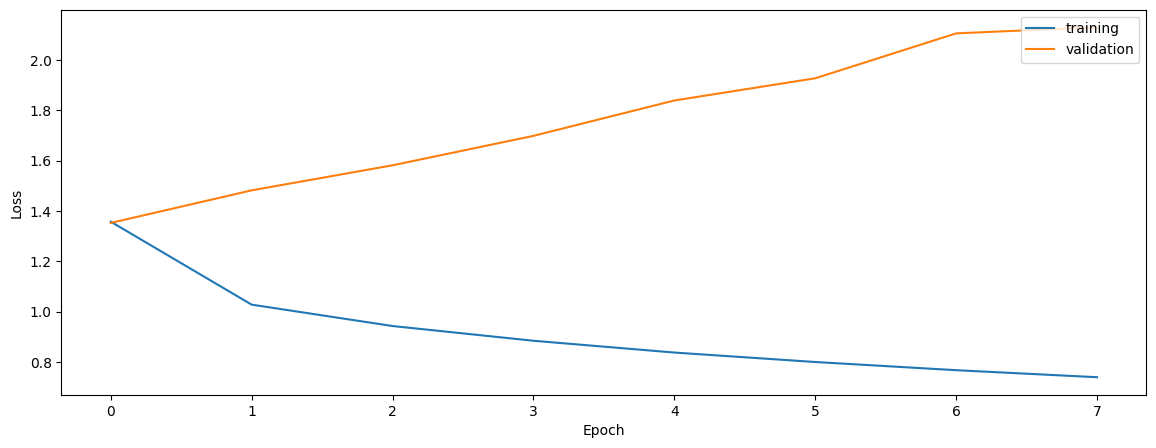

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.5607508414584512
0.4646862615651411
0.44237846131796704


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5534304802774077
0.4991559265597895
0.4833953655901069


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5539684926243339
0.5066817240730285
0.4816690297751671


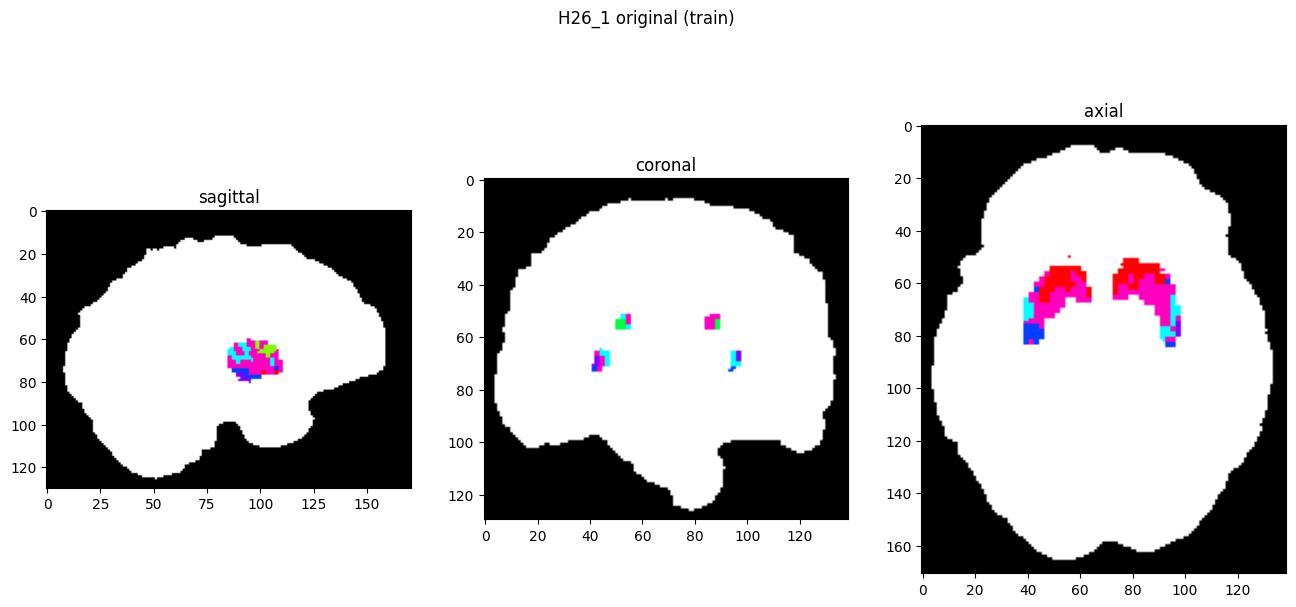

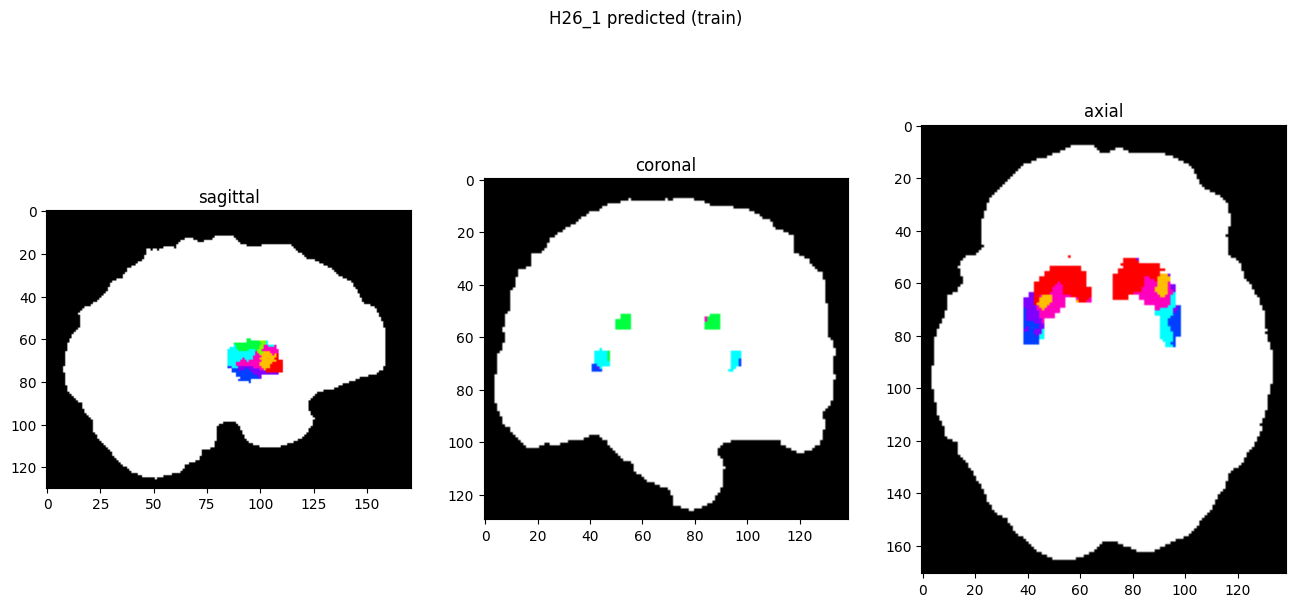

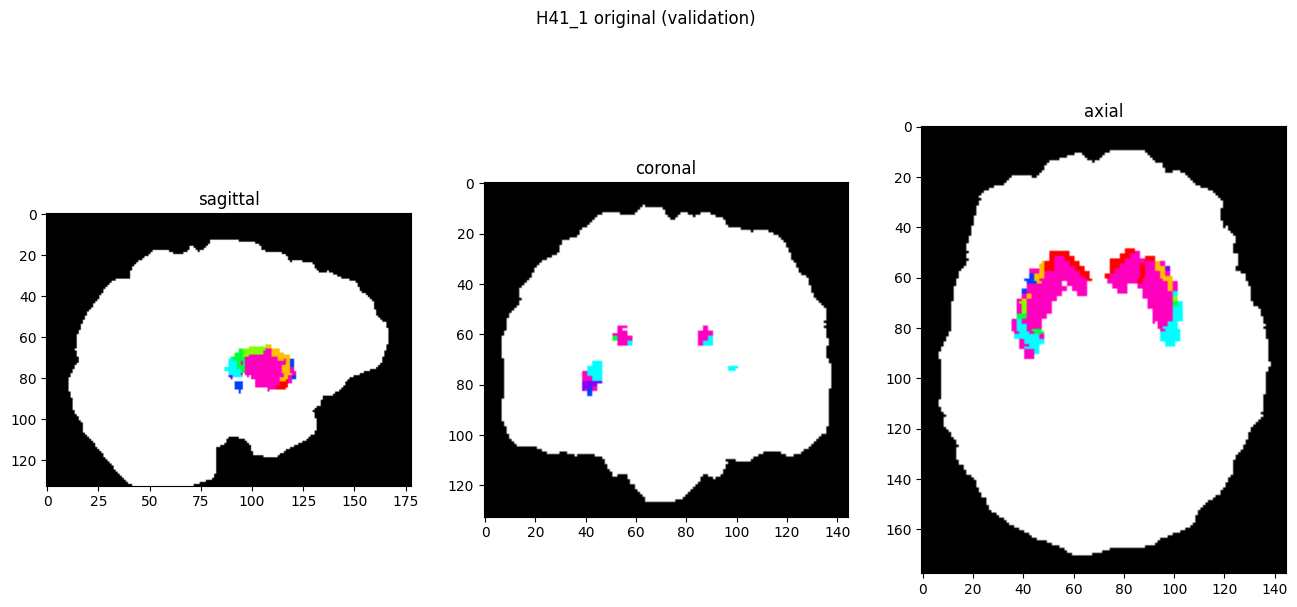

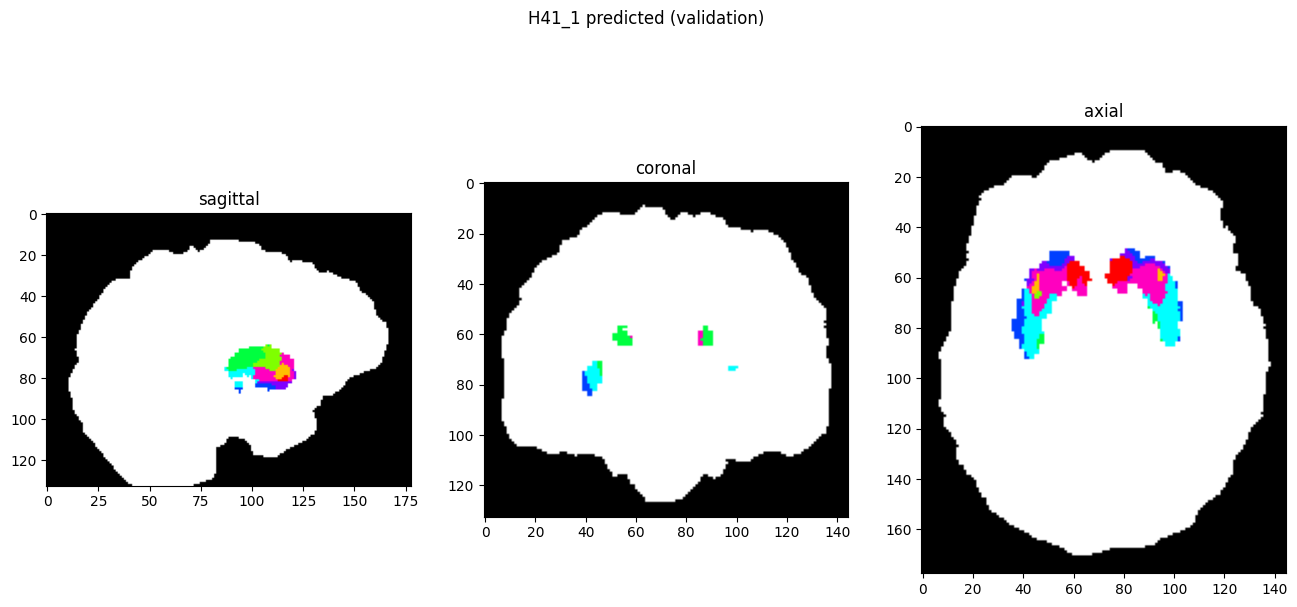

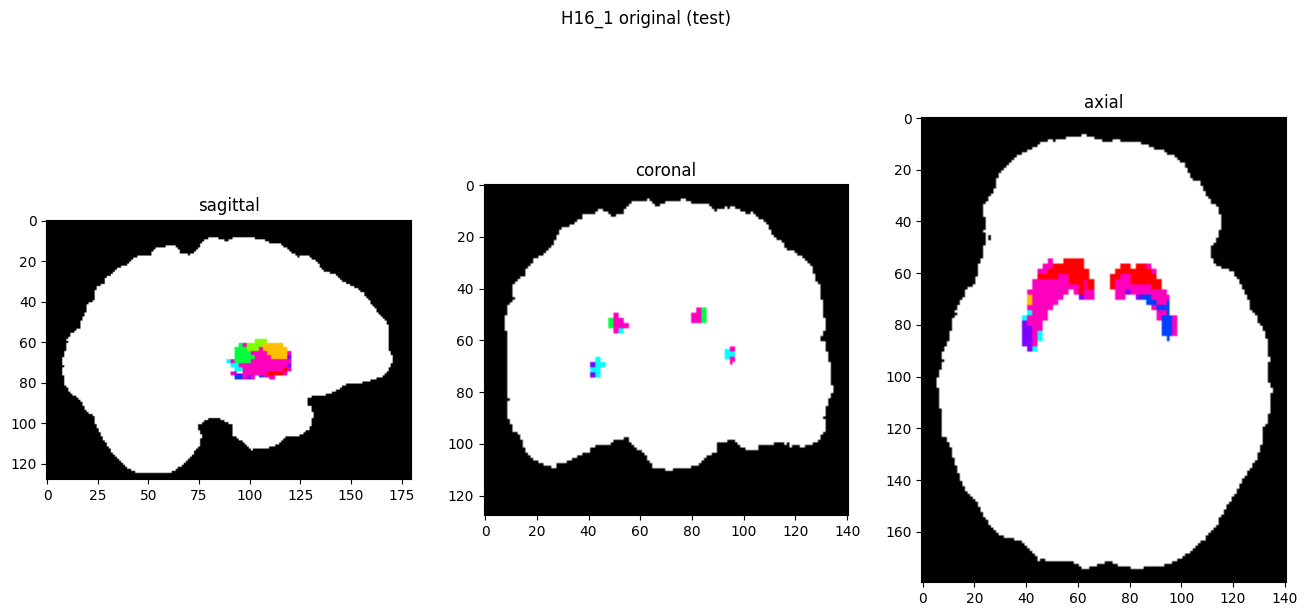

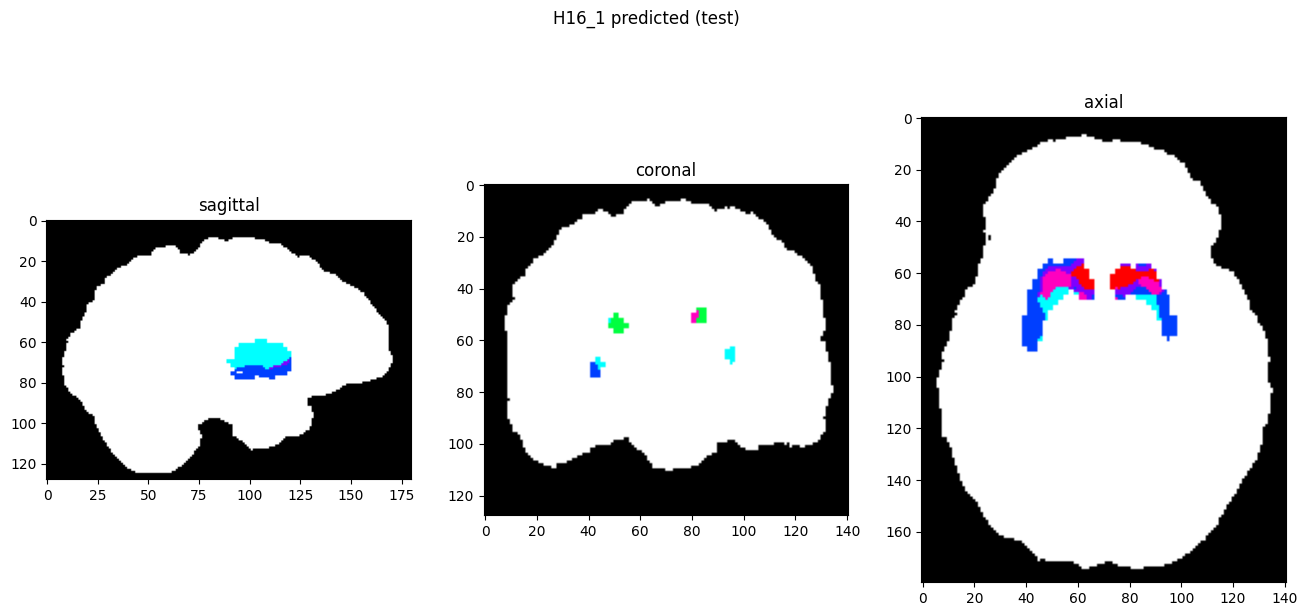

In [10]:
showResults(model, gen, threshold=0)